# Raoul Herskovits Extract 10 Python Notebook

## Part 1: Package Importing, Data Cleaning and Reading
**Objectives**
1. Import Packages and Read the IPUMS microdata extract into a pandas DataFrame
2. Create new analytical columns which express relevant data and prepare it for future aggregation
3. Create a set of functions which will allow us to trim down future dataframes for visualization purposes
4. Create a set of Trimmed dataframes to assist with shapefile merging
5. Read the Enumeration District Shapefiles 
6. Aggregate our microdata based on Enumeration District, and merge them with their respective shapefiles into GeoDataFrames

### 1. Import Packages and Read the IPUMS microdata extract into a pandas DataFrame

In [372]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### This file is an extract of census data from the Full Censuses of 1880 through 1940, isolated for only Kings County (Brooklyn) NY

The 1880 census information can help with broader analysis, but we will not be plotting it by enumeration district.

For more information about the extract, see the .cbk codebook file in the repository.


In [373]:
# Read In Our Data and take a peek
filepath = '/Users/raoulherskoits/Documents/GIS Work/BMT_Thesis_largedatasets/IPUMS/microdata_extract_11/usa_00011.csv'
df = pd.read_csv(filepath)

In [374]:
print("shape:", df.shape)
print('-------------')
print(df.dtypes)
print('-------------')
df.head()

shape: (7936470, 34)
-------------
YEAR             int64
SAMPLE           int64
SERIAL           int64
HHWT           float64
STATEFIP         int64
COUNTYICP        int64
GQ               int64
ENUMDIST         int64
PERNUM           int64
SEX              int64
AGE              int64
RACE             int64
RACED            int64
HISPAN           int64
HISPAND          int64
BPL              int64
BPLD             int64
MBPL             int64
MBPLD            int64
FBPL             int64
FBPLD            int64
NATIVITY         int64
OCC1950          int64
IND1950          int64
VERSIONHIST      int64
HISTID          object
MBPL_MOM       float64
MBPL_POP       float64
MBPL_MOM2      float64
MBPL_POP2      float64
FBPL_MOM       float64
FBPL_POP       float64
FBPL_MOM2      float64
FBPL_POP2      float64
dtype: object
-------------


YEAR  SAMPLE   SERIAL  HHWT  STATEFIP  COUNTYICP  GQ  ENUMDIST  PERNUM  \
0  1880  188003  5999091   1.0        36        470   1  47000001       1   
1  1880  188003  5999091   1.0        36        470   1  47000001       2   
2  1880  188003  5999091   1.0        36        470   1  47000001       3   
3  1880  188003  5999091   1.0        36        470   1  47000001       4   
4  1880  188003  5999091   1.0        36        470   1  47000001       5   

   SEX  ...  VERSIONHIST                                HISTID  MBPL_MOM  \
0    2  ...            2  9FF5A2DD-D229-4B87-A50E-73957C2CFBC8       NaN   
1    2  ...            2  6E9CB7D7-4B60-4551-B3FF-2E05A4CC280A      36.0   
2    2  ...            2  F020F0B3-D539-43A5-9EFE-A6F5BCDF2E23      36.0   
3    2  ...            2  CA33FAA3-9408-4037-A56F-7F09851FFBD1      36.0   
4    2  ...            2  D0351FAD-DFF1-457A-82B1-D87F2AC514A2       NaN   

   MBPL_POP  MBPL_MOM2  MBPL_POP2  FBPL_MOM  FBPL_POP  FBPL_MOM2  FBPL_POP2  
0       NaN        NaN        NaN       NaN       NaN        NaN        NaN  
1       NaN        NaN        NaN      36.0       NaN        NaN        NaN  
2       NaN        NaN        NaN      36.0       NaN        NaN        NaN  
3       NaN        NaN        NaN      36.0       NaN        NaN        NaN  
4       NaN        NaN        NaN       NaN       NaN        NaN        NaN  

[5 rows x 34 columns]

### 2. Create new analytical columns which express relevant data and prepare it for future aggregation

Our original file consists of microdata where all values in columns are codes referring to a specific classification.
Without overloading on a column because there are too many codes.

#### I. General Categories
We make Boolean Columns for Group Quarters status, Immigrant statuse, and Second Generation Immigrant Status (that is, if someone is the child of immigrants)

In [375]:
# make a column for whether or not they live in group quarters
df['ISGQ'] = (df['GQ']>2)

# make columns based on immigrant status
df['ISIMMIGRANT'] = ((df['NATIVITY']==5)|(df['BPL']>99)) #In case of error in the "nativity" entry, we also check if birthplace was outside of the USA
df['ISGENTWO'] = ((df['NATIVITY'].isin([2, 3, 4]))|(df['MBPL']>99)|(df['FBPL']>99)) #for the children of immigrants

df['TOTAL_POP'] = 1 #This will help in the future with counting total population using aggregation. For now it is essentially useless.


#### II. Demographics

We make columns for a wide variety of Racial and Ethnic groups, casting a wide net so as to not miss any possible trends in our analysis. These categories were chosen out of a combination of Red-Hook specific population interest (hence the inclusion of Puerto Rican and Filipino categories, despite their small minority), as well as an iterative addition of white ethnic categories which Exploratory Data Analysis showed to be a significant part of the Brooklyn population (i.e. the Slavic and Scandinavian categories).

In [376]:

# Make columns for our Ethnic/Racial Groups

df['ISPR'] = (
    (df['HISPAN']==2) #Checking Hispanic census variable for "Puerto Rican" category
    |(df['MBPL']==110)|(df['FBPL']==110) #Checking if mother or father is born in PR
    |((df['FBPL_POP']==110)&(df['MBPL_POP']==110)) #Checking grandparents birthplaces for PR 
    |((df['FBPL_MOM']==110)&(df['MBPL_MOM']==110))
    )

# A more general Hispanic category
df['ISHISPAN'] = df['HISPAN'].isin([2, 3, 4])

# Also, an extra set for the Filipino population, which our research has suggersted may be a
# possibly significant Latino Population
df['ISFILIPINO'] = (
    (df['BPL']==515)|(df['MBPL']==515)|(df['FBPL']==515)
    |((df['FBPL_POP']==515)&(df['MBPL_POP']==515))
    |((df['FBPL_MOM']==515)&(df['MBPL_MOM']==515))
    )

# Of course, a subdivision for the Black population, despite its seeming lack of 
# prevalance in Red Hook before the 1960's
df['ISBLACK'] = (df['RACE']==2)


# Now we make columns for general White identity, as well as the major ethnic subdivisions which we 
# see in in NYC over this time period
df['ISWHITE'] = (
    (df['RACE']==1) 
    & ((df['HISPAND']==000)|(df['HISPAND']==480)) #Including people from Spain as white
    ) #Hispan 480 is Spanish, which we will include

# Italian Identity Groups
df['ITALYBPL'] = (df['BPL']==434)
df['ISITALIAN'] = (
    #Check for mothers, fathers, or own birthplace as italy
    (df['MBPL']==434)|(df['FBPL']==434)|(df['ITALYBPL']==1)
    # Check for grandparent birthplase as italy. 
    # We will say that if at least two grandparents were born in Italy, it counts.
    |((df['FBPL_POP']==434)&(df['MBPL_POP']==434))
    |((df['FBPL_MOM']==434)&(df['MBPL_MOM']==434))
                  )

df['ISWHITE_NON_ITALIAN'] = ((df['ISWHITE']==1)&(df['ISITALIAN']==0)).astype(int)

# German,  
df['ISGERMAN'] = (
    (df['BPL']==453)|(df['MBPL']==453)|(df['FBPL']==453)
    |((df['FBPL_POP']==453)&(df['MBPL_POP']==453))
    |((df['FBPL_MOM']==453)&(df['MBPL_MOM']==453))
    )

# Slavic
slav_codes = [452, 452, 455, 457, 465] #These include the Slavic countries (see codebook)
df['ISSLAVIC'] = (
    (df['BPL'].isin(slav_codes))|(df['MBPL'].isin(slav_codes))|(df['FBPL'].isin(slav_codes))
    |((df['FBPL_POP'].isin(slav_codes))&(df['MBPL_POP'].isin(slav_codes)))
    |((df['FBPL_MOM'].isin(slav_codes))&(df['MBPL_MOM'].isin(slav_codes)))
    )

# Irish,
df['ISIRISH'] = (
    (df['BPL']==414)|(df['MBPL']==414)|(df['FBPL']==414)
    |((df['FBPL_POP']==414)&(df['MBPL_POP']==414))
    |((df['FBPL_MOM']==414)&(df['MBPL_MOM']==414))
    )

# Scandinavian
scan_codes = list(range(400, 406))
df['ISSCANDI'] = (
    (df['BPL'].isin(scan_codes))|(df['MBPL'].isin(scan_codes))|(df['FBPL'].isin(scan_codes))
    |((df['FBPL_POP'].isin(scan_codes))&(df['MBPL_POP'].isin(scan_codes)))
    |((df['FBPL_MOM'].isin(scan_codes))&(df['MBPL_MOM'].isin(scan_codes)))
    )


# Compiling major groups into one
df['DEMO_GROUP'] = 0
df.loc[df['ISIMMIGRANT'], 'DEMO_GROUP'] = 1
df.loc[df['ISSLAVIC'], 'DEMO_GROUP'] = 2
df.loc[df['ISIRISH'], 'DEMO_GROUP'] = 3
df.loc[df['ISSCANDI'], 'DEMO_GROUP'] = 4
df.loc[df['ISGERMAN'], 'DEMO_GROUP'] = 5
df.loc[df['ISITALIAN'], 'DEMO_GROUP'] = 6
df.loc[df['ISBLACK'], 'DEMO_GROUP'] = 7
df.loc[df['ISPR'], 'DEMO_GROUP'] = 8


# Redefine our Demographic columns to eliminate overlap
df['IS_OTHER_NATIVE'] = (df['DEMO_GROUP']==0)
df['IS_OTHER_IMMIGRANT'] = (df['DEMO_GROUP']==1)
df['ISSLAVIC'] = (df['DEMO_GROUP']==2)
df['ISIRISH'] = (df['DEMO_GROUP']==3)
df['ISSCANDI'] = (df['DEMO_GROUP']==4)
df['ISGERMAN'] = (df['DEMO_GROUP']==5)
df['ISITALIAN'] = (df['DEMO_GROUP']==6)
df['ISBLACK'] = (df['DEMO_GROUP']==7)
df['ISPR'] = (df['DEMO_GROUP']==8)

df['DEMO_GROUP'].value_counts()


0    2225160
2    1549305
3    1068800
5    1005304
6     987149
1     625968
4     263646
7     192253
8      18885
Name: DEMO_GROUP, dtype: int64

#### III. employment

We start by creating columns for the general occupation categories demarcated by the census codes (see the codebook for more details)

In [377]:
# make a column for people marked unemployed and people with no employment data

df['UNEMPLOYED'] = ((df['OCC1950'] < 997)&(df['OCC1950'] > 979)) #as it turns out, very few people are listed as unemployed
df['OCC_UNKNOWN'] = (df['OCC1950'].isin([999, 997]))


# Make a simplified version of the occupation data
df['OCC_CATEGORY'] = df['OCC1950']//100
df.loc[(df['UNEMPLOYED']), 'OCC_CATEGORY'] = 10
df.loc[(df['OCC_UNKNOWN']), 'OCC_CATEGORY'] = -1

# Get Dummies of this column, to isolate job category as a boolean variable per person
df['OCC_CATEGORY_DUMMY'] = df['OCC_CATEGORY']
df = pd.get_dummies(df, prefix=['OCC_CATEGORY'], columns=['OCC_CATEGORY_DUMMY'])

# Delete duplicates just in case
df = df.loc[:,~df.columns.duplicated()].copy()


We then rename these columns to reflect their occupation category

In [378]:
del df['OCC_CATEGORY_-1'] # we already have OCC_UNKNOWN
del df['OCC_CATEGORY_10'] # we already have UNEMPLOYED
df = df.rename(columns={
    'OCC_CATEGORY_0': 'OCC_PRO/TECH',
    'OCC_CATEGORY_1': 'OCC_FARM',
    'OCC_CATEGORY_2': 'OCC_MAN/OFF/PROP',
    'OCC_CATEGORY_3': 'OCC_CLERICAL',
    'OCC_CATEGORY_4': 'OCC_SALES',
    'OCC_CATEGORY_5': 'OCC_CRAFTS',
    'OCC_CATEGORY_6': 'OCC_OP',
    'OCC_CATEGORY_7': 'OCC_SERVICE',
    'OCC_CATEGORY_8': 'OCC_FARMLAB',
    'OCC_CATEGORY_9': 'OCC_LAB', 
})


Now we start making columns for categorizations of Longshoring labor. There is a single code in the occupation entry which is labeled "Longshoremen/Stevedores" and which we will use as our primary indicator of the longshoring profession.

In [379]:

# Make a column for people working on the docks themselves

# This is a more generous interpretation of who would be working on the docks, including the codes for:
# Longshoremen/Stevedores, Sailors/Deckhands), and those in "water transportation" Industry
# df['ISDOCKWORKER'] = ((df['OCC1950'].isin([940, 673]))|(df['IND1950']==546)).astype(int) 

# Our dockworker column will just be for people we are 100% sure are Longshoremen/Stevedores
df['ISDOCKWORKER'] = ((df['OCC1950']==940))



# Make a superset column for more general waterfront-related laborers

# Define generally waterfront-related job codes
# See Codebook for chosen occupations
waterfront_jobs = [940, 950, 673, 623]
# Let's do the same for waterfront-related industries
# See codebook for chosen industries 
waterfront_industries = [546, 506, 527, 378, 379]
# Create the column using both lists
df['ISWATERFRONT'] = ((df['OCC1950'].isin(waterfront_jobs)) | (df['IND1950'].isin(waterfront_industries)))


# Make a more accurate column for all industrial laborers

# list of general industrial labor categories
# See codebook
industrial_industries = [246, 307, 308, 318, 336, 337, 338, 346, 347, 357, 358, 367, 376, 378, 379, 399, 499, 506, 526, 527, 546, 568, 976, 673]

# We will count anyone who's Occupation falls within the "laborer" or "operative"
df['ISINDUSTRY'] = ((df['OCC_CATEGORY']==9) | (df['OCC_CATEGORY']==6) | (df['IND1950'].isin(industrial_industries)))


# Make a Column Aggregating These Job Categories

# since 'ISINDUSTRY' contains 'ISWATERFRONT' contains 'ISDOCKWORKER', we can do this by summing
df['JOB_GROUP'] = df[['ISINDUSTRY', 'ISWATERFRONT', 'ISDOCKWORKER']].sum(axis=1) + 1
# make a value for unemployed
df.loc[(df['JOB_GROUP']==1)&(df['UNEMPLOYED']), 'JOB_GROUP'] = 0
# make a value for unknown occupation
df.loc[df['OCC_UNKNOWN'], 'JOB_GROUP'] = -1



**Later, we make dummy columns for ALL occupation codes, but we cannot do this with a dataframe of this size, as it crashes python**

#### IV. Compound Columns
Because we will need to aggregate our data when we merge with our shapefiles, we will need columns that represent a combination of attributes, namely demographic and employment.

In [380]:

for demo in ['ISPR', 'ISHISPAN', 'ISFILIPINO', 'ISWHITE', 'ISBLACK',
       'ITALYBPL', 'ISITALIAN', 'ISGERMAN', 'ISSLAVIC',
       'ISIRISH', 'ISSCANDI', 'IS_OTHER_NATIVE',
       'IS_OTHER_IMMIGRANT', 'ISGQ']:
    for category in ['UNEMPLOYED', 'OCC_UNKNOWN',
       'OCC_PRO/TECH', 'OCC_FARM', 'OCC_MAN/OFF/PROP', 'OCC_CLERICAL',
       'OCC_SALES', 'OCC_CRAFTS', 'OCC_OP', 'OCC_SERVICE', 'OCC_FARMLAB',
       'OCC_LAB', 'OCC_PRO/TECH', 'OCC_FARM', 'OCC_MAN/OFF/PROP',
       'OCC_CLERICAL', 'OCC_SALES', 'OCC_CRAFTS', 'OCC_OP', 'OCC_SERVICE',
       'OCC_FARMLAB', 'OCC_LAB', 'ISDOCKWORKER', 'ISWATERFRONT', 'ISINDUSTRY', 'ISGQ', 'ISIMMIGRANT']:
        df[f'{demo}_AND_{category}'] = (df[demo]) & (df[category])
        # print(f'checked {demo} and {category}')


# Delete duplicates just in case
df = df.loc[:,~df.columns.duplicated()].copy()

/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3031667230.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{demo}_AND_{category}'] = (df[demo]) & (df[category])
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3031667230.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{demo}_AND_{category}'] = (df[demo]) & (df[category])
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3031667230.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the re

### 3. Create a set of functions which will allow us to trim down future dataframes for visualization purposes
This can be useful for our Exploratory Data Analysis, but we will not be using these functions regularly.

#### Make a function which isolates only the primary demographic groups of this project's interest
This function will only be used for comparing these demographics, while the first dataframe will still be used for more general calculations

In [381]:
# A filtered dataframe which isolates our six primary demographic groups
def reduce_demographic(df):
    return df[df['DEMO_GROUP']>1]

#### Make a function which drops all rows of unrecorded occupation

In [382]:
def drop_unrecorded_jobs(df):
    return df[df['JOB_GROUP']!=-1]

This function can be used for visualizing employed populations without having to drop unrecorded values every time. In general, though, we cannot eliminate these populations from our analysis.

### 4. Create a set of Trimmed dataframes to assist with shapefile merging

In [383]:
# dataframes separated by census year

df_1880 = df[df['YEAR']==1880] #this one is not really necessary
df_1900 = df[df['YEAR']==1900]
df_1910 = df[df['YEAR']==1910]
df_1920 = df[df['YEAR']==1920]
df_1930 = df[df['YEAR']==1930]
df_1940 = df[df['YEAR']==1940]

### 5. Read the Enumeration District Shapefiles and merge them with our DataFrame into a set of GeoDataFrames
Enumeration District labels and boundaries changed every decade, and do not currently exist in a digital shapefile format. Using AncestryLibrary and the National Archives, I have drawn each district in our area of interest and assigned them their correct labels. I have included these shapefiles in the repository both in their pure CRS form, and a projected form (EPSG:2263) which will be in this analysis to get an accurate calculation of polygon area.

More details on each year below.

#### 1900
These district boundaries were available through AncestryLibrary:

Ancestry.com. 1900 United States Federal Census [database on-line]. Lehi, UT, USA: Ancestry.com Operations Inc, 2004.

https://www.ancestrylibrary.com/search/collections/7602/

In [384]:
shp1900 = gpd.read_file('/Users/raoulherskoits/Documents/GIS Work/BMT_Thesis_largedatasets/shapefiles/enumeration_districts_1900/enumeration_districts_1900_projected.shp')
print(shp1900.head())

   1900label                                           geometry
0   47000168  POLYGON ((-74.01292 40.67732, -74.01142 40.676...
1   47000167  POLYGON ((-74.01416 40.67815, -74.01292 40.677...
2   47000169  POLYGON ((-74.01416 40.67815, -74.01224 40.679...
3   47000175  POLYGON ((-73.99873 40.67648, -73.99537 40.675...
4   47000176  POLYGON ((-74.00136 40.67575, -73.99933 40.675...


#### 1910
These district boundaries were available through AncestryLibrary:

Ancestry.com. 1910 United States Federal Census [database on-line]. Lehi, UT, USA: Ancestry.com Operations Inc, 2006.

https://www.ancestrylibrary.com/search/collections/7884/

In [385]:
shp1910 = gpd.read_file('/Users/raoulherskoits/Documents/GIS Work/BMT_Thesis_largedatasets/shapefiles/enumeration_districts_1910/enumeration_districts_1910_projected.shp')
shp1910.head()

1910label                                           geometry
0   47000240  POLYGON ((979896.566 184291.988, 979462.128 18...
1   47000241  POLYGON ((980559.089 185091.035, 980146.342 18...
2   47000242  POLYGON ((980321.809 186345.804, 981081.790 18...
3   47000243  POLYGON ((981191.829 186629.212, 981599.865 18...
4   47000244  POLYGON ((980853.954 186942.961, 981191.829 18...

#### 1920
These district boundaries were available through AncestryLibrary:

Ancestry.com. 1920 United States Federal Census [database on-line]. Provo, UT, USA: Ancestry.com Operations, Inc., 2010. Images reproduced by FamilySearch.

https://www.ancestrylibrary.com/search/collections/6061/

In [386]:
shp1920 = gpd.read_file('/Users/raoulherskoits/Documents/GIS Work/BMT_Thesis_largedatasets/shapefiles/enumeration_districts_1920/enumeration_districts_1920_projected.shp')
shp1920.head()

id  1920label                                           geometry
0  None   47000124  POLYGON ((984125.152 190531.403, 984044.815 19...
1  None   47000125  POLYGON ((984840.877 189699.993, 984749.561 18...
2  None   47000126  POLYGON ((984749.561 189449.787, 984504.505 18...
3  None   47000127  POLYGON ((984537.453 189543.434, 984293.003 18...
4  None   47000128  POLYGON ((983869.702 189827.156, 984279.394 18...

#### 1930

These district boundaries were available through AncestryLibrary:

Ancestry.com. 1930 United States Federal Census [database on-line]. Provo, UT, USA: Ancestry.com Operations Inc, 2002.

https://www.ancestrylibrary.com/search/collections/6224/

In [387]:
shp1930 = gpd.read_file('/Users/raoulherskoits/Documents/GIS Work/BMT_Thesis_largedatasets/shapefiles/enumeration_districts_1930/enumeration_districts_1930_projected.shp')

# I had included an etra feature, but we have no need for it
del shp1930['1940label']
shp1930.head()

1930label                                           geometry
0   47001710  POLYGON ((979804.375 185765.180, 979387.212 18...
1   47000957  POLYGON ((983236.142 188113.073, 982558.777 18...
2   47000975  POLYGON ((980853.954 186942.961, 981191.829 18...
3   47000973  POLYGON ((979804.375 185765.180, 979152.204 18...
4   47001716  POLYGON ((982825.375 182607.205, 983266.511 18...

#### 1940

Finding the enumeration district shapes and their corresponding code numbers was a more involved process for 1940.
Comparing to the list of districts here:
https://www.ancestrylibrary.com/search/collections/2442/
we see that the majority of district names in the dataset end with 0 while most of the ones in AncestryLibrary end in another digit, sometimes even a letter.

In [388]:
df.loc[(df['YEAR']==1940)&(df['ENUMDIST']%10 != 0)].groupby('ENUMDIST').size()

ENUMDIST
2400101    835
2400102    131
2400281    899
2400282    858
2400341    458
          ... 
2425902    103
2425921    893
2425922    669
2425931    130
2425932    188
Length: 714, dtype: int64

In [389]:
df.loc[(df['YEAR']==1940)&(df['ENUMDIST']%10 == 0)].groupby('ENUMDIST').size()

ENUMDIST
2400010    1307
2400020     360
2400030     352
2400040      15
2400050     868
           ... 
2428590     471
2428600     487
2428610     430
2428620     407
2428630     422
Length: 2446, dtype: int64

It seems as though district names are shifted one digit to the left to give room for another digit, used to designate a new differentiator used in this census: alphabetic codes at the end of some districts.

e.g. enumeration district 1025:
in the written districts, there are two districts 1025 (1025A and 1025B), and no districts 10251 or 10252.

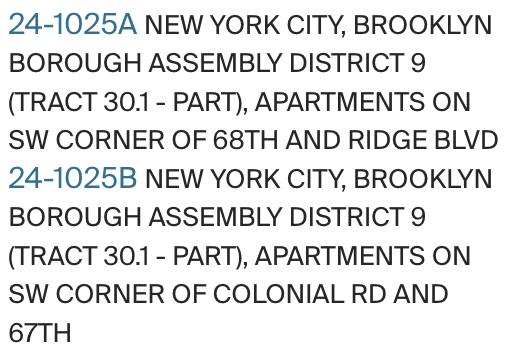

However in the dataset...

In [390]:
print(df.loc[(df['YEAR']==1940)&(df['ENUMDIST'] == 2401025)].groupby('ENUMDIST').size())
# There are no districts simply labeled 1025

print('\n ------------------- \n')

print(df.loc[(df['YEAR']==1940)&(df['ENUMDIST']//10==241025)].groupby('ENUMDIST').size())
# and there are are two districts 10251 and 10252!

Series([], dtype: int64)

 ------------------- 

ENUMDIST
2410251    793
2410252    723
dtype: int64


This seems to be strong evidence that the last digit is reserved to designate the alphabetic label, and the label is not eliminated.

We can try again with another district, 1031, which has three alphabetic designations: A, B, and C.

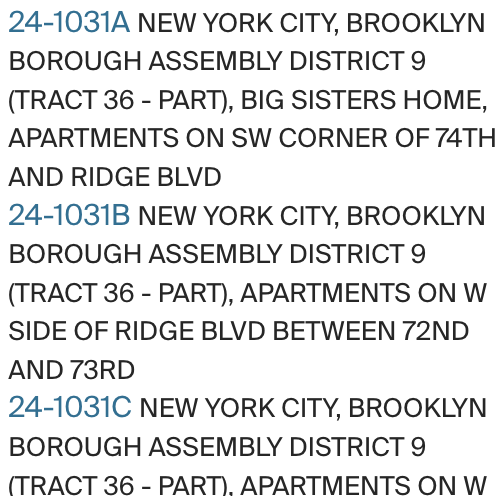

In [391]:
print('Rows with enumeration district ending in 1031:')

print(df.loc[(df['YEAR']==1940)&(df['ENUMDIST']%10000==1031)].groupby('ENUMDIST').size())

print('\n ------------------- \n')

print('Rows with enumeration district ending 1031 + another digit')
print(df.loc[(df['YEAR']==1940)&(df['ENUMDIST']//10==241031)].groupby('ENUMDIST').size())

Rows with enumeration district ending in 1031:
Series([], dtype: int64)

 ------------------- 

Rows with enumeration district ending 1031 + another digit
ENUMDIST
2410311    603
2410312    705
2410313    302
dtype: int64


As we can see, the final digit once again matches the three alphabetic labels perfectly

In [392]:
df.loc[(df['YEAR']==1930)&(df['DEMO_GROUP']==6),'ENUMDIST'].value_counts()

47001161    2520
47001430    2194
47001134    2010
47001770    1838
47001939    1555
            ... 
47000672       1
47000803       1
47001515       1
47000799       1
47000802       1
Name: ENUMDIST, Length: 1782, dtype: int64

With that knowledge, we can label our polygons correctly, and load them in.

In [393]:
shp1940 = gpd.read_file('/Users/raoulherskoits/Documents/GIS Work/BMT_Thesis_largedatasets/shapefiles/enumeration_districts_1940/enumeration_districts_1940_projected.shp')
shp1940.head()

id  1940label                                           geometry
0  None    2404991  POLYGON ((981081.845 185673.296, 981599.865 18...
1  None    2404992  POLYGON ((981873.009 185718.879, 982007.688 18...
2  None    2404993  POLYGON ((982361.124 186270.009, 982700.143 18...
3  None    2404994  POLYGON ((981873.009 185718.879, 981939.408 18...
4  None    2404930  POLYGON ((979804.375 185765.180, 979387.212 18...

#### Special Districts: Hostpitals/Schools
There are a set of districts which are better mapped by points as opposed to polygons, as they refer to the property of specific institutions. Because they cannot be mapped in the same way as the other data, and only refer to special cases such as hospitals, universities, and churches (ostensibly removed from the industrial waterfront), I have refrained from incoorperating them in this analysis.

### 6. Aggregate our microdata based on Enumeration District, and merge them with their respective shapefiles into GeoDataFrames

First, trim our Decade-Specific dataframes to only contain the data from our region of interest: Red Hook
And rename their enumeration district labels to match those of the shapefiles

In [394]:
df_1900_redhook = df_1900[df_1900['ENUMDIST'].isin(shp1900['1900label'])]
df_1910_redhook = df_1910[df_1910['ENUMDIST'].isin(shp1910['1910label'])]
df_1920_redhook = df_1920[df_1920['ENUMDIST'].isin(shp1920['1920label'])]
df_1930_redhook = df_1930[df_1930['ENUMDIST'].isin(shp1930['1930label'])]
df_1940_redhook = df_1940[df_1940['ENUMDIST'].isin(shp1940['1940label'])]

df_redhook = pd.concat([df_1900_redhook, df_1910_redhook, df_1920_redhook, df_1930_redhook, df_1940_redhook], ignore_index=True)

#### Now, our dataframes are small enough to "get_dummies" i.e., make boolean columns, for all of our occupation codes.
We will also perform a similar "check both" function on our occupation codes (now boolean colunms) and our demographic columns.

In [395]:
df_1900_redhook['ISITALIAN'].sum()

6161

In [396]:
len(df_1900_redhook[df_1900_redhook['ISITALIAN']])

6161

In [397]:
def occdummies(df):
   
    # Make dummies for occupation in case of future aggregation
    df['OCC1950_DUMMY'] = df['OCC1950']
    df = pd.get_dummies(df, columns=['OCC1950_DUMMY'], prefix='OCC1950')

     # get rid of any duplicate columns
    df = df.loc[:,~df.columns.duplicated()].copy()
    
    # Make boolean columns checking for occupation and other demographic features
    #To not create a needlessly bloated number of columns, let's only create these intersections for occupation 
    # columns which apply to more than 100 people in all of Red Hook that census year, as breaking such a small number
    # down even further by demographic doesn't seem very useful
    occupations = [title for title in df.columns if title[:8]=='OCC1950_' and df[title].sum()>100] #The last clause ensures a certain population of workers of that job
    minor_occupations = [title for title in df.columns if title[:8]=='OCC1950_' and df[title].sum()<=50]
    print(occupations)
    print(minor_occupations)
    
    for occupation in occupations:
        
        #Now create boolean intersection columns with our other demographic data
        for demo in ['ISPR', 'ISHISPAN', 'ISFILIPINO', 'ISWHITE', 'ISBLACK',
       'ITALYBPL', 'ISITALIAN', 'ISGERMAN', 'ISSLAVIC',
       'ISIRISH', 'ISSCANDI', 'IS_OTHER_NATIVE',
       'IS_OTHER_IMMIGRANT', 'ISGQ']:
            df[f'{demo}_AND_{occupation}'] = ((df[demo]) & (df[occupation]))

    # get rid of any duplicate columns
    df = df.loc[:,~df.columns.duplicated()].copy()

    return df

df_redhook = occdummies(df_redhook)

['OCC1950_0', 'OCC1950_1', 'OCC1950_4', 'OCC1950_9', 'OCC1950_35', 'OCC1950_36', 'OCC1950_43', 'OCC1950_46', 'OCC1950_54', 'OCC1950_55', 'OCC1950_57', 'OCC1950_58', 'OCC1950_73', 'OCC1950_74', 'OCC1950_75', 'OCC1950_78', 'OCC1950_93', 'OCC1950_99', 'OCC1950_100', 'OCC1950_203', 'OCC1950_210', 'OCC1950_240', 'OCC1950_290', 'OCC1950_310', 'OCC1950_320', 'OCC1950_321', 'OCC1950_335', 'OCC1950_340', 'OCC1950_342', 'OCC1950_350', 'OCC1950_360', 'OCC1950_365', 'OCC1950_370', 'OCC1950_380', 'OCC1950_390', 'OCC1950_430', 'OCC1950_450', 'OCC1950_470', 'OCC1950_490', 'OCC1950_500', 'OCC1950_501', 'OCC1950_502', 'OCC1950_503', 'OCC1950_504', 'OCC1950_505', 'OCC1950_510', 'OCC1950_512', 'OCC1950_515', 'OCC1950_523', 'OCC1950_533', 'OCC1950_534', 'OCC1950_540', 'OCC1950_544', 'OCC1950_550', 'OCC1950_554', 'OCC1950_561', 'OCC1950_564', 'OCC1950_570', 'OCC1950_571', 'OCC1950_573', 'OCC1950_574', 'OCC1950_575', 'OCC1950_581', 'OCC1950_582', 'OCC1950_583', 'OCC1950_584', 'OCC1950_585', 'OCC1950_590', '

/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{demo}_AND_{occupation}'] = ((df[demo]) & (df[occupation]))
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{demo}_AND_{occupation}'] = ((df[demo]) & (df[occupation]))
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is us

As seen below, this process creates a very large number of boolean variables, which will preserve as much data as possible when we aggregate this microdate into groups by Enumeration District.

In [398]:
print("# of Columns in Original Dataframe")
print(len(df.columns))

print("# of Columns After New Conditional Columns Created")
print(len(df_redhook.columns))

# of Columns in Original Dataframe
308
# of Columns After New Conditional Columns Created
2255


Now, we make a function which performs a series of operations, producing a version of the inputted dataframe where each row is now an entire enumeration district, and its values for each variable (including all the combinations of factors such as 'is Black and is a Longshoreman') now express the counts of true values in the microdata---that is to say, the number of people in that district who fit into the given category.

For example if there were 15 rows (people) in the previous dataframe with enumeration district number of 4700023 and an occupation code of 320 (cashiers), and they were all Scandinavian, the post-aggregation dataframe would contain a single row for enumeration district 4700023, and a column titled "ISSCANDI_AND_OCC1950_320" with a value of 15. There would also obviously be columns "ISSCANDI" (the Scandinavian population) and "OCC1950_320" (the cashier population) which would both likely be larger than their intersection column.

In [399]:
def group_enum (df, label):
    
    # Make the large set of boolean columns described above
    df = occdummies(df)
    
    # Create one last new column which, when summed, will represent the number of microdata rows 
    # (i.e. people) in

    # df = dummydf.loc[:,~dummydf.columns.duplicated()].copy() #gets rid of duplicate columns
    
    df.rename(columns={'ENUMDIST': label}, inplace=True)
    
    # Drop all non-aggregatable columns and group by Enumeration District
    trimdf = df.drop(columns=['SAMPLE', 'SERIAL', 'HHWT', 'STATEFIP', 'COUNTYICP', 'GQ', 'PERNUM', 'SEX', 'AGE', 'RACE', 'RACED', 'HISPAN',
       'HISPAND', 'BPL', 'BPLD', 'MBPL', 'MBPLD', 'FBPL', 'FBPLD',
       'NATIVITY', 'OCC1950', 'IND1950', 'VERSIONHIST', 'HISTID',
       'MBPL_MOM', 'MBPL_POP', 'MBPL_MOM2', 'MBPL_POP2', 'FBPL_MOM',
       'FBPL_POP', 'FBPL_MOM2', 'FBPL_POP2', 'DEMO_GROUP', 'OCC_CATEGORY', 'JOB_GROUP', 'YEAR'])
    
    # print(trimdf.head())
    aggdf = trimdf.groupby(label).sum().reset_index()
    # print(aggdf.columns[aggdf.columns.duplicated()])   for bugfixing
    return aggdf


df_1900_enumgroupsums = group_enum(df_1900_redhook, '1900label')
df_1910_enumgroupsums = group_enum(df_1910_redhook, '1910label')
df_1920_enumgroupsums = group_enum(df_1920_redhook, '1920label')
df_1930_enumgroupsums = group_enum(df_1930_redhook, '1930label')
df_1940_enumgroupsums = group_enum(df_1940_redhook, '1940label')

['OCC1950_57', 'OCC1950_93', 'OCC1950_100', 'OCC1950_240', 'OCC1950_290', 'OCC1950_310', 'OCC1950_340', 'OCC1950_342', 'OCC1950_350', 'OCC1950_365', 'OCC1950_390', 'OCC1950_430', 'OCC1950_490', 'OCC1950_500', 'OCC1950_501', 'OCC1950_502', 'OCC1950_503', 'OCC1950_504', 'OCC1950_510', 'OCC1950_512', 'OCC1950_515', 'OCC1950_523', 'OCC1950_544', 'OCC1950_561', 'OCC1950_564', 'OCC1950_574', 'OCC1950_582', 'OCC1950_583', 'OCC1950_585', 'OCC1950_590', 'OCC1950_591', 'OCC1950_594', 'OCC1950_623', 'OCC1950_633', 'OCC1950_643', 'OCC1950_644', 'OCC1950_673', 'OCC1950_680', 'OCC1950_683', 'OCC1950_690', 'OCC1950_700', 'OCC1950_710', 'OCC1950_720', 'OCC1950_740', 'OCC1950_750', 'OCC1950_754', 'OCC1950_763', 'OCC1950_770', 'OCC1950_773', 'OCC1950_780', 'OCC1950_781', 'OCC1950_784', 'OCC1950_940', 'OCC1950_970', 'OCC1950_979', 'OCC1950_980', 'OCC1950_983', 'OCC1950_999']
['OCC1950_0', 'OCC1950_1', 'OCC1950_3', 'OCC1950_4', 'OCC1950_5', 'OCC1950_6', 'OCC1950_7', 'OCC1950_9', 'OCC1950_29', 'OCC1950_31'

/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OCC1950_DUMMY'] = df['OCC1950']
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{demo}_AND_{occupation}'] = ((df[demo]) & (df[occupation]))
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

['OCC1950_57', 'OCC1950_93', 'OCC1950_240', 'OCC1950_290', 'OCC1950_310', 'OCC1950_320', 'OCC1950_340', 'OCC1950_342', 'OCC1950_350', 'OCC1950_370', 'OCC1950_390', 'OCC1950_430', 'OCC1950_470', 'OCC1950_490', 'OCC1950_500', 'OCC1950_501', 'OCC1950_502', 'OCC1950_503', 'OCC1950_504', 'OCC1950_510', 'OCC1950_512', 'OCC1950_515', 'OCC1950_523', 'OCC1950_544', 'OCC1950_564', 'OCC1950_573', 'OCC1950_574', 'OCC1950_582', 'OCC1950_583', 'OCC1950_585', 'OCC1950_590', 'OCC1950_594', 'OCC1950_623', 'OCC1950_632', 'OCC1950_633', 'OCC1950_643', 'OCC1950_644', 'OCC1950_645', 'OCC1950_673', 'OCC1950_680', 'OCC1950_683', 'OCC1950_690', 'OCC1950_700', 'OCC1950_710', 'OCC1950_720', 'OCC1950_740', 'OCC1950_750', 'OCC1950_752', 'OCC1950_753', 'OCC1950_754', 'OCC1950_761', 'OCC1950_762', 'OCC1950_763', 'OCC1950_764', 'OCC1950_770', 'OCC1950_773', 'OCC1950_780', 'OCC1950_784', 'OCC1950_790', 'OCC1950_940', 'OCC1950_960', 'OCC1950_970', 'OCC1950_979', 'OCC1950_983', 'OCC1950_984', 'OCC1950_999']
['OCC1950_0

/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{demo}_AND_{occupation}'] = ((df[demo]) & (df[occupation]))
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{demo}_AND_{occupation}'] = ((df[demo]) & (df[occupation]))
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is us

['OCC1950_93', 'OCC1950_240', 'OCC1950_290', 'OCC1950_310', 'OCC1950_340', 'OCC1950_342', 'OCC1950_350', 'OCC1950_370', 'OCC1950_390', 'OCC1950_490', 'OCC1950_500', 'OCC1950_501', 'OCC1950_503', 'OCC1950_504', 'OCC1950_510', 'OCC1950_512', 'OCC1950_515', 'OCC1950_523', 'OCC1950_544', 'OCC1950_554', 'OCC1950_564', 'OCC1950_574', 'OCC1950_582', 'OCC1950_583', 'OCC1950_585', 'OCC1950_590', 'OCC1950_594', 'OCC1950_632', 'OCC1950_633', 'OCC1950_643', 'OCC1950_644', 'OCC1950_673', 'OCC1950_680', 'OCC1950_682', 'OCC1950_683', 'OCC1950_690', 'OCC1950_700', 'OCC1950_710', 'OCC1950_720', 'OCC1950_740', 'OCC1950_750', 'OCC1950_753', 'OCC1950_754', 'OCC1950_763', 'OCC1950_764', 'OCC1950_770', 'OCC1950_773', 'OCC1950_780', 'OCC1950_781', 'OCC1950_784', 'OCC1950_940', 'OCC1950_960', 'OCC1950_970', 'OCC1950_979', 'OCC1950_980', 'OCC1950_983', 'OCC1950_999']
['OCC1950_1', 'OCC1950_3', 'OCC1950_4', 'OCC1950_5', 'OCC1950_6', 'OCC1950_7', 'OCC1950_8', 'OCC1950_29', 'OCC1950_32', 'OCC1950_33', 'OCC1950_34

/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{demo}_AND_{occupation}'] = ((df[demo]) & (df[occupation]))
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{demo}_AND_{occupation}'] = ((df[demo]) & (df[occupation]))
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is us

['OCC1950_93', 'OCC1950_240', 'OCC1950_290', 'OCC1950_310', 'OCC1950_340', 'OCC1950_342', 'OCC1950_350', 'OCC1950_370', 'OCC1950_390', 'OCC1950_430', 'OCC1950_490', 'OCC1950_500', 'OCC1950_504', 'OCC1950_510', 'OCC1950_512', 'OCC1950_515', 'OCC1950_523', 'OCC1950_544', 'OCC1950_550', 'OCC1950_554', 'OCC1950_564', 'OCC1950_573', 'OCC1950_574', 'OCC1950_583', 'OCC1950_585', 'OCC1950_590', 'OCC1950_594', 'OCC1950_632', 'OCC1950_633', 'OCC1950_643', 'OCC1950_644', 'OCC1950_673', 'OCC1950_680', 'OCC1950_682', 'OCC1950_683', 'OCC1950_690', 'OCC1950_700', 'OCC1950_720', 'OCC1950_740', 'OCC1950_754', 'OCC1950_761', 'OCC1950_763', 'OCC1950_770', 'OCC1950_773', 'OCC1950_780', 'OCC1950_784', 'OCC1950_790', 'OCC1950_940', 'OCC1950_970', 'OCC1950_979', 'OCC1950_980', 'OCC1950_982', 'OCC1950_983', 'OCC1950_984', 'OCC1950_999']
['OCC1950_0', 'OCC1950_1', 'OCC1950_2', 'OCC1950_3', 'OCC1950_4', 'OCC1950_5', 'OCC1950_6', 'OCC1950_7', 'OCC1950_8', 'OCC1950_9', 'OCC1950_28', 'OCC1950_29', 'OCC1950_32', 'O

/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{demo}_AND_{occupation}'] = ((df[demo]) & (df[occupation]))
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{demo}_AND_{occupation}'] = ((df[demo]) & (df[occupation]))
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is us

['OCC1950_93', 'OCC1950_290', 'OCC1950_310', 'OCC1950_340', 'OCC1950_342', 'OCC1950_350', 'OCC1950_390', 'OCC1950_430', 'OCC1950_490', 'OCC1950_500', 'OCC1950_510', 'OCC1950_512', 'OCC1950_523', 'OCC1950_544', 'OCC1950_550', 'OCC1950_554', 'OCC1950_564', 'OCC1950_574', 'OCC1950_585', 'OCC1950_590', 'OCC1950_632', 'OCC1950_643', 'OCC1950_644', 'OCC1950_673', 'OCC1950_680', 'OCC1950_683', 'OCC1950_685', 'OCC1950_690', 'OCC1950_720', 'OCC1950_740', 'OCC1950_754', 'OCC1950_761', 'OCC1950_763', 'OCC1950_770', 'OCC1950_780', 'OCC1950_784', 'OCC1950_790', 'OCC1950_940', 'OCC1950_970', 'OCC1950_980', 'OCC1950_982', 'OCC1950_990', 'OCC1950_995', 'OCC1950_999']
['OCC1950_1', 'OCC1950_3', 'OCC1950_4', 'OCC1950_5', 'OCC1950_6', 'OCC1950_7', 'OCC1950_8', 'OCC1950_9', 'OCC1950_29', 'OCC1950_31', 'OCC1950_32', 'OCC1950_33', 'OCC1950_35', 'OCC1950_36', 'OCC1950_42', 'OCC1950_43', 'OCC1950_44', 'OCC1950_45', 'OCC1950_46', 'OCC1950_47', 'OCC1950_51', 'OCC1950_52', 'OCC1950_54', 'OCC1950_55', 'OCC1950_56

/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{demo}_AND_{occupation}'] = ((df[demo]) & (df[occupation]))
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{demo}_AND_{occupation}'] = ((df[demo]) & (df[occupation]))
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/3472095535.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is us

Finally, merge our aggregated dataframes with their corresponding shapefiles!

In [465]:
# A function to merge aggregated data with enumeration district shapefiles
def merge_enum(df, shp, label):
    merged_df = pd.merge(shp, df, on=label, how='inner')

    # Turn it into a GeoDataFrame
    gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')

    # Reindex to turn the enumeration district label into a normal column
    gdf.reset_index(drop=True, inplace=True)

    # Let's also make columns for variables as percentages of the enumeration district's total population
    # We will only do this for significant columns, though, with at least 200 members
    significant_columns = [column for column in gdf.columns if (gdf[column].dtype == 'int64') and (gdf[column].sum() > 500)]
    # print('significant_columns:')
    print(np.array(significant_columns))
    for column in significant_columns:
        gdf[f'{column}_PERCENT'] = 0
        gdf.loc[gdf[column] != 0, f'{column}_PERCENT'] = ((gdf[column] / gdf['TOTAL_POP']) * 100)

    print(gdf[f'{column}_PERCENT'])

    # Finally, make a column with the areas of each district (this can be useful for possible spatial density measurements)
    gdf['AREA'] = gdf['geometry'].area
    # gdf[f'{label[:4]}_AREA'] = gdf['geometry'].area ----- This will include the date of the dataframe in the area column label

    return gdf

# Perform the function for our five censuses

gdf_1900 = merge_enum(df_1900_enumgroupsums, shp1900,label='1900label')
gdf_1910 = merge_enum(df_1910_enumgroupsums, shp1910,label='1910label')
gdf_1920 = merge_enum(df_1920_enumgroupsums, shp1920,label='1920label')
gdf_1930 = merge_enum(df_1930_enumgroupsums, shp1930,label='1930label')
gdf_1940 = merge_enum(df_1940_enumgroupsums, shp1940,label='1940label')

['1900label' 'ISGQ' 'ISIMMIGRANT' 'ISGENTWO' 'TOTAL_POP' 'ISWHITE'
 'ITALYBPL' 'ISITALIAN' 'ISWHITE_NON_ITALIAN' 'ISGERMAN' 'ISSLAVIC'
 'ISIRISH' 'ISSCANDI' 'IS_OTHER_NATIVE' 'IS_OTHER_IMMIGRANT' 'UNEMPLOYED'
 'OCC_UNKNOWN' 'ISDOCKWORKER' 'ISWATERFRONT' 'ISINDUSTRY'
 'ISWHITE_AND_UNEMPLOYED' 'ISWHITE_AND_OCC_UNKNOWN'
 'ISWHITE_AND_OCC_PRO/TECH' 'ISWHITE_AND_OCC_MAN/OFF/PROP'
 'ISWHITE_AND_OCC_CLERICAL' 'ISWHITE_AND_OCC_SALES'
 'ISWHITE_AND_OCC_CRAFTS' 'ISWHITE_AND_OCC_OP' 'ISWHITE_AND_OCC_SERVICE'
 'ISWHITE_AND_OCC_LAB' 'ISWHITE_AND_ISDOCKWORKER'
 'ISWHITE_AND_ISWATERFRONT' 'ISWHITE_AND_ISINDUSTRY' 'ISWHITE_AND_ISGQ'
 'ISWHITE_AND_ISIMMIGRANT' 'ITALYBPL_AND_OCC_UNKNOWN'
 'ITALYBPL_AND_OCC_CRAFTS' 'ITALYBPL_AND_OCC_LAB'
 'ITALYBPL_AND_ISDOCKWORKER' 'ITALYBPL_AND_ISWATERFRONT'
 'ITALYBPL_AND_ISINDUSTRY' 'ITALYBPL_AND_ISIMMIGRANT'
 'ISITALIAN_AND_OCC_UNKNOWN' 'ISITALIAN_AND_OCC_CRAFTS'
 'ISITALIAN_AND_OCC_LAB' 'ISITALIAN_AND_ISDOCKWORKER'
 'ISITALIAN_AND_ISWATERFRONT' 'ISITALIAN_AND_ISIND

/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/1678816326.py:18: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  gdf.loc[gdf[column] != 0, f'{column}_PERCENT'] = ((gdf[column] / gdf['TOTAL_POP']) * 100)
/opt/anaconda3/envs/geodata/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/anaconda3/envs/geodata/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: PerformanceWarning: DataFrame is highly fragmented.  This is usua

0     2.831257
1     3.043478
2     3.298153
3     1.213347
4     1.617647
5     1.085271
6     1.151079
7     1.671975
8     1.251739
9     2.233903
10    1.351351
11    1.352875
12    0.763359
13    1.038062
14    1.821862
15    1.995565
16    1.773050
17    1.092044
18    1.174168
19    0.686948
20    2.685512
21    4.809287
22    1.053864
23    0.490196
24    1.078838
25    3.914429
26    1.599289
27    3.304348
28    0.430571
29    0.218103
30    0.771605
31    2.032520
32    2.435978
33    1.593625
34    1.600854
35    0.509684
36    0.682128
37    0.939850
38    0.164880
39    0.427046
40    0.715308
41    0.767018
42    1.114206
43    1.029963
44    0.752508
45    1.534919
46    1.980198
47    0.428266
48    1.397516
49    1.970443
50    2.552048
51    2.369338
52    2.035088
53    1.334380
54    1.929530
55    1.883053
Name: IS_OTHER_IMMIGRANT_AND_OCC1950_999_PERCENT, dtype: float64
['1920label' 'ISGQ' 'ISIMMIGRANT' 'ISGENTWO' 'TOTAL_POP' 'ISHISPAN'
 'ISWHITE' 'ITALYBPL' 'ISIT

/opt/anaconda3/envs/geodata/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/1678816326.py:18: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  gdf.loc[gdf[column] != 0, f'{column}_PERCENT'] = ((gdf[column] / gdf['TOTAL_POP']) * 100)
/opt/anaconda3/envs/geodata/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: PerformanceWarning: DataFrame is highly fragmented.  This is usua

['1930label' 'ISGQ' 'ISIMMIGRANT' 'ISGENTWO' 'TOTAL_POP' 'ISPR' 'ISHISPAN'
 'ISBLACK' 'ISWHITE' 'ITALYBPL' 'ISITALIAN' 'ISWHITE_NON_ITALIAN'
 'ISGERMAN' 'ISSLAVIC' 'ISIRISH' 'ISSCANDI' 'IS_OTHER_NATIVE'
 'IS_OTHER_IMMIGRANT' 'UNEMPLOYED' 'OCC_UNKNOWN' 'ISDOCKWORKER'
 'ISWATERFRONT' 'ISINDUSTRY' 'ISPR_AND_OCC_UNKNOWN' 'ISPR_AND_ISINDUSTRY'
 'ISPR_AND_ISIMMIGRANT' 'ISHISPAN_AND_OCC_UNKNOWN' 'ISHISPAN_AND_OCC_OP'
 'ISHISPAN_AND_OCC_LAB' 'ISHISPAN_AND_ISINDUSTRY'
 'ISHISPAN_AND_ISIMMIGRANT' 'ISWHITE_AND_UNEMPLOYED'
 'ISWHITE_AND_OCC_UNKNOWN' 'ISWHITE_AND_OCC_PRO/TECH'
 'ISWHITE_AND_OCC_MAN/OFF/PROP' 'ISWHITE_AND_OCC_CLERICAL'
 'ISWHITE_AND_OCC_SALES' 'ISWHITE_AND_OCC_CRAFTS' 'ISWHITE_AND_OCC_OP'
 'ISWHITE_AND_OCC_SERVICE' 'ISWHITE_AND_OCC_LAB'
 'ISWHITE_AND_ISDOCKWORKER' 'ISWHITE_AND_ISWATERFRONT'
 'ISWHITE_AND_ISINDUSTRY' 'ISWHITE_AND_ISGQ' 'ISWHITE_AND_ISIMMIGRANT'
 'ITALYBPL_AND_OCC_UNKNOWN' 'ITALYBPL_AND_OCC_MAN/OFF/PROP'
 'ITALYBPL_AND_OCC_CRAFTS' 'ITALYBPL_AND_OCC_OP'
 'ITALYBPL_AND_

/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_17343/1678816326.py:18: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  gdf.loc[gdf[column] != 0, f'{column}_PERCENT'] = ((gdf[column] / gdf['TOTAL_POP']) * 100)
/opt/anaconda3/envs/geodata/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/anaconda3/envs/geodata/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: PerformanceWarning: DataFrame is highly fragmented.  This is usua

In [466]:
gdf_1900['ISITALIAN'] / gdf_1900['TOTAL_POP']

0     0.028682
1     0.029133
2     0.126392
3     0.031496
4     0.067922
5     0.027964
6     0.015103
7     0.011019
8     0.112755
9     0.068690
10    0.014523
11    0.112653
12    0.179290
13    0.013858
14    0.107250
15    0.038631
16    0.013019
17    0.016827
18    0.180897
19    0.016591
20    0.008403
21    0.183326
22    0.492746
23    0.758194
24    0.020216
25    0.010092
26    0.002872
27    0.024691
28    0.044308
29    0.011984
30    0.051414
31    0.017407
32    0.029868
33    0.021031
34    0.031228
35    0.009241
36    0.017184
dtype: float64

## Part 2. Exploratory Data Analysis

### 1. explore our larger, brooklyn-wide data and compare it to our red hook-specific dataframes
Let's get a sense of the data we are working with!

**Start With Total Demographic Population Numbers**

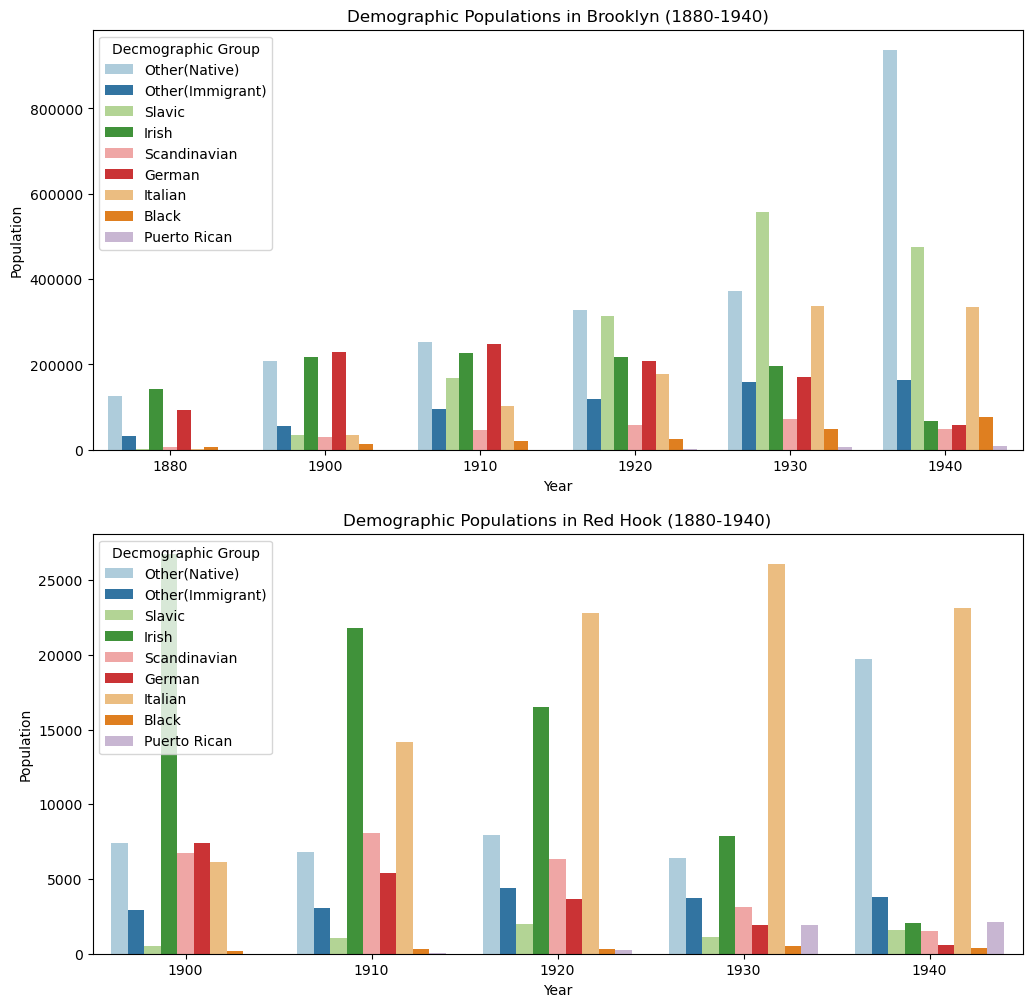

In [467]:
# Plot the count of waterfront jobs over the decades by race group in Brooklyn as a whole and in Red Hook
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

sns.countplot(data=df, x='YEAR', hue='DEMO_GROUP', palette='Paired', ax=axes[0])
axes[0].set_title("Demographic Populations in Brooklyn (1880-1940)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Population")
axes[0].legend(title='Decmographic Group', labels= ['Other(Native)', 'Other(Immigrant)', 'Slavic', 'Irish', 'Scandinavian', 'German', 'Italian', 'Black', 'Puerto Rican'])

sns.countplot(data=df_redhook, x='YEAR', hue='DEMO_GROUP', palette='Paired', ax=axes[1])
axes[1].set_title("Demographic Populations in Red Hook (1880-1940)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Population")
axes[1].legend(title='Decmographic Group', labels= ['Other(Native)', 'Other(Immigrant)', 'Slavic', 'Irish', 'Scandinavian', 'German', 'Italian', 'Black', 'Puerto Rican'])
plt.show()

As we can see in Red Hook, the Irish and Italian mirror each other's increase/decrease in population, while the number of Native non-ethnic whites spikes from 1930-1940. Note the rise in Puerto Rican population in 1930 as well.

What about these "Other" categories? Let's look at the other(immigrant) category first. Where are these immigrants coming from?

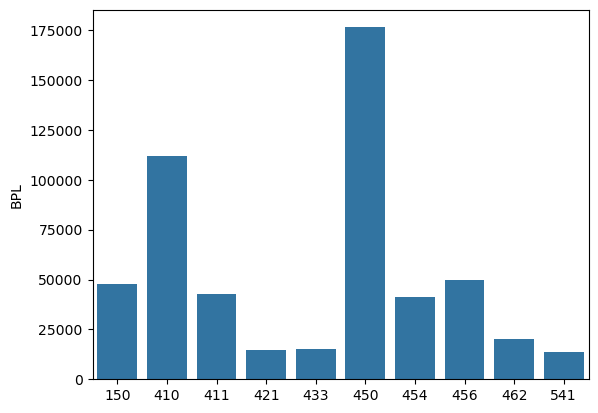

In [468]:
sns.barplot(data=df.loc[df['DEMO_GROUP']==1, 'BPL'].value_counts().head(10))

plt.xticks = ['Canada', 'Engl']

And as for the other(native) category, are these just native White people?

**Longshoremen/Stevedore Jobs Over Time**

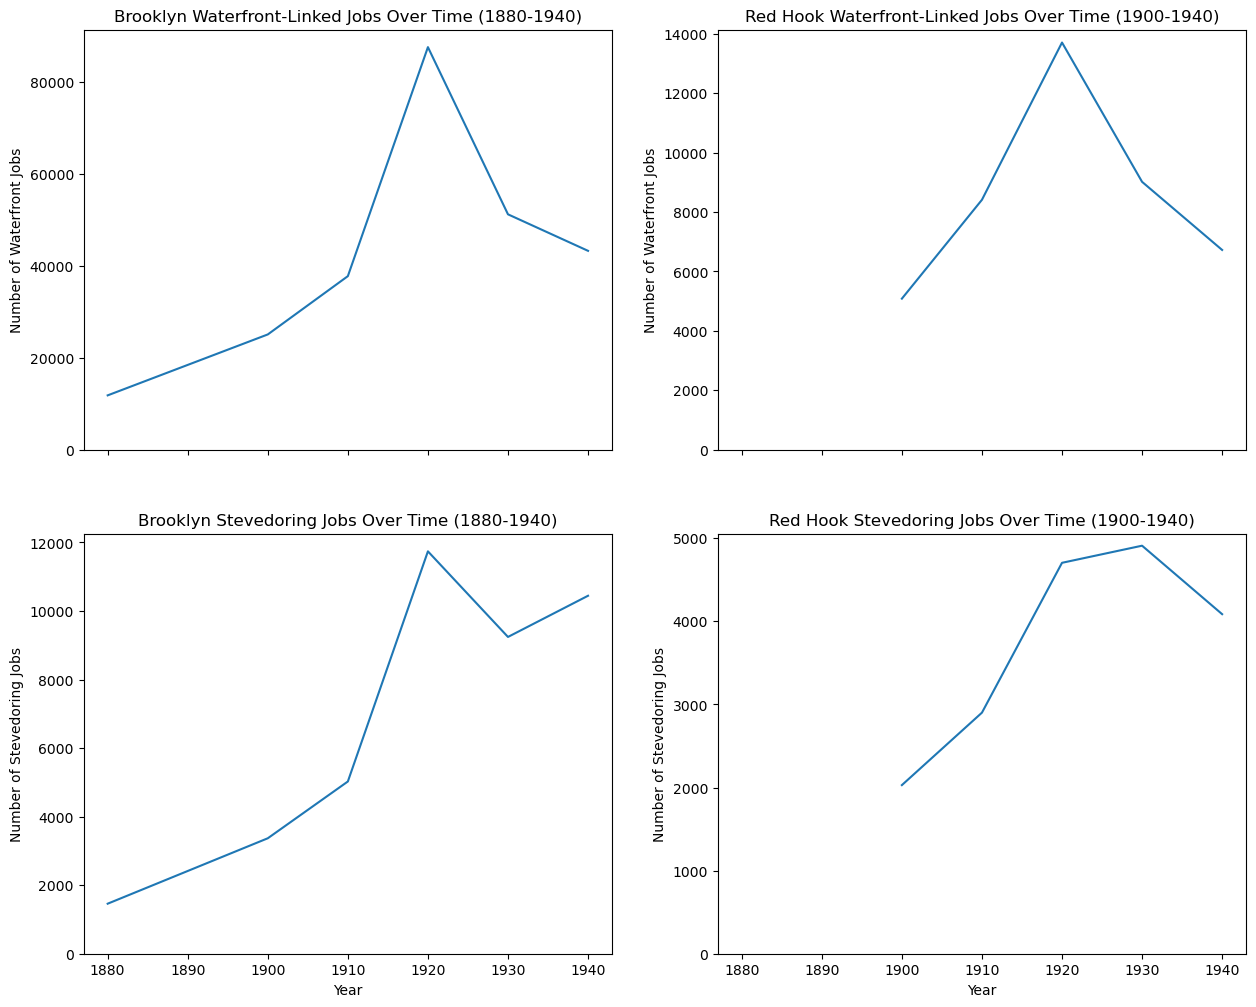

In [469]:
# Plot Stevedoring and general Waterfront Industrial Jobs Over Time in Brooklyn and Red Hook

# Data preparation
wfjob_counts = df.groupby('YEAR')['ISWATERFRONT'].sum().reset_index()
dockjob_counts = df.groupby('YEAR')['ISDOCKWORKER'].sum().reset_index()

# Create subplots with 2 rows and 1 column
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)

# Plot 1: Waterfront-Linked Jobs Over Time
sns.lineplot(data=wfjob_counts, x='YEAR', y='ISWATERFRONT', ax=axes[0, 0])
axes[0, 0].set_title("Brooklyn Waterfront-Linked Jobs Over Time (1880-1940)")
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("Number of Waterfront Jobs")
axes[0, 0].set_ylim(ymin=0)

# Plot 2: Stevedoring Jobs Over Time
sns.lineplot(data=dockjob_counts, x='YEAR', y='ISDOCKWORKER', ax=axes[1, 0])
axes[1, 0].set_title("Brooklyn Stevedoring Jobs Over Time (1880-1940)")
axes[1, 0].set_xlabel("Year")
axes[1, 0].set_ylabel("Number of Stevedoring Jobs")
axes[1, 0].set_ylim(ymin=0)


# Now For the Red Hook Plots
rhwf_counts = df_redhook.groupby('YEAR')['ISWATERFRONT'].sum().reset_index()
rhdock_counts = df_redhook.groupby('YEAR')['ISDOCKWORKER'].sum().reset_index()

# Plot 3: Waterfront jobs in Red Hook
sns.lineplot(data=rhwf_counts, x='YEAR', y='ISWATERFRONT', ax=axes[0, 1])
axes[0, 1].set_title("Red Hook Waterfront-Linked Jobs Over Time (1900-1940)")
axes[0, 1].set_xlabel("Year")
axes[0, 1].set_ylabel("Number of Waterfront Jobs")
axes[0, 1].set_ylim(ymin=0)

# Finally, stevedoring jobs in red hook
sns.lineplot(data=rhdock_counts, x='YEAR', y='ISDOCKWORKER', ax=axes[1, 1])
axes[1, 1].set_title("Red Hook Stevedoring Jobs Over Time (1900-1940)")
axes[1, 1].set_xlabel("Year")
axes[1, 1].set_ylabel("Number of Stevedoring Jobs")
axes[1, 1].set_ylim(ymin=0)

# Show the plots
plt.show()

**Dockworkers Over Time by Demographic;**

Brooklyn and Red Hook

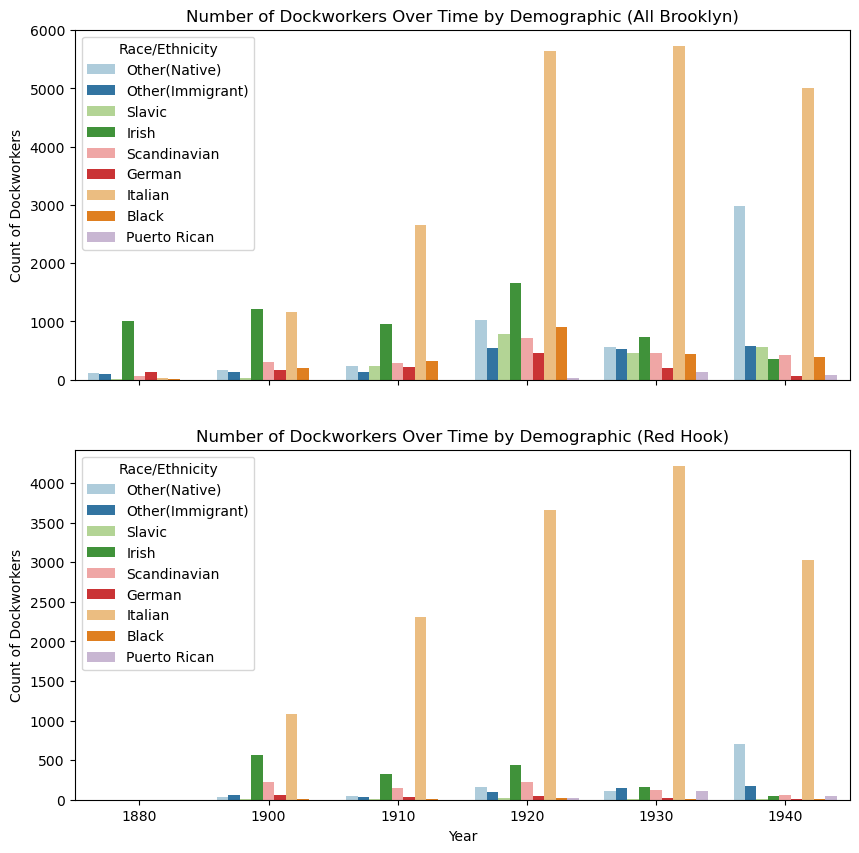

In [470]:
df_dock = df[df['ISDOCKWORKER']]
df_redhookdock = df_redhook[df_redhook['ISDOCKWORKER']]
# isolate just Stevedoring Population

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

sns.countplot(data=df_dock, x='YEAR', hue='DEMO_GROUP', palette='Paired', ax=axes[0])
axes[0].set_title("Number of Dockworkers Over Time by Demographic (All Brooklyn)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Count of Dockworkers")
axes[0].legend(title='Race/Ethnicity', labels= ['Other(Native)', 'Other(Immigrant)', 'Slavic', 'Irish', 'Scandinavian', 'German', 'Italian', 'Black', 'Puerto Rican'])

sns.countplot(data=df_redhookdock, x='YEAR', hue='DEMO_GROUP', palette='Paired', ax=axes[1])
axes[1].set_title("Number of Dockworkers Over Time by Demographic (Red Hook)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Count of Dockworkers")
axes[1].legend(title='Race/Ethnicity', labels= ['Other(Native)', 'Other(Immigrant)', 'Slavic', 'Irish', 'Scandinavian', 'German', 'Italian', 'Black', 'Puerto Rican'])



plt.show()

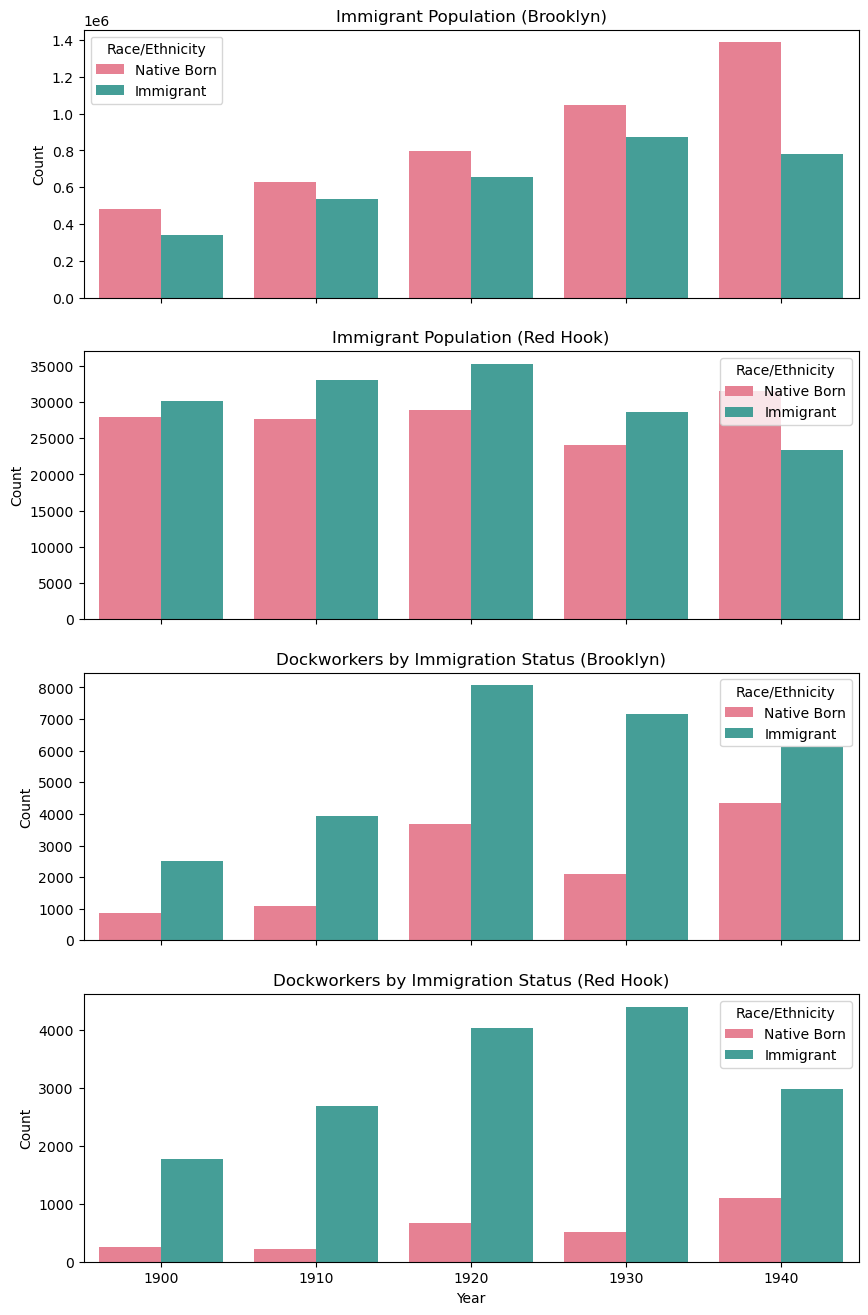

In [471]:
fig, axes = plt.subplots(4, 1, figsize=(10, 16), sharex=True)

sns.countplot(data=df[df['YEAR']!=1880], x='YEAR', hue='ISIMMIGRANT', palette='husl', ax=axes[0])
axes[0].set_title("Immigrant Population (Brooklyn)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Count")
axes[0].legend(title='Race/Ethnicity', labels= ['Native Born', 'Immigrant'])

sns.countplot(data=df_redhook, x='YEAR', hue='ISIMMIGRANT', palette='husl', ax=axes[1])
axes[1].set_title("Immigrant Population (Red Hook)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Count")
axes[1].legend(title='Race/Ethnicity', labels= ['Native Born', 'Immigrant'])

sns.countplot(data=df_dock[df_dock['YEAR']!=1880], x='YEAR', hue='ISIMMIGRANT', palette='husl', ax=axes[2])
axes[2].set_title("Dockworkers by Immigration Status (Brooklyn)")
axes[2].set_xlabel("Year")
axes[2].set_ylabel("Count")
axes[2].legend(title='Race/Ethnicity', labels= ['Native Born', 'Immigrant'])

sns.countplot(data=df_redhook[df_redhook['ISDOCKWORKER']], x='YEAR', hue='ISIMMIGRANT', palette='husl', ax=axes[3])
axes[3].set_title("Dockworkers by Immigration Status (Red Hook)")
axes[3].set_xlabel("Year")
axes[3].set_ylabel("Count")
axes[3].legend(title='Race/Ethnicity', labels= ['Native Born', 'Immigrant'])



What is the explanation for this jarring shift? It must be a data issue.

**Immigrant Longshoremen by Demographic**

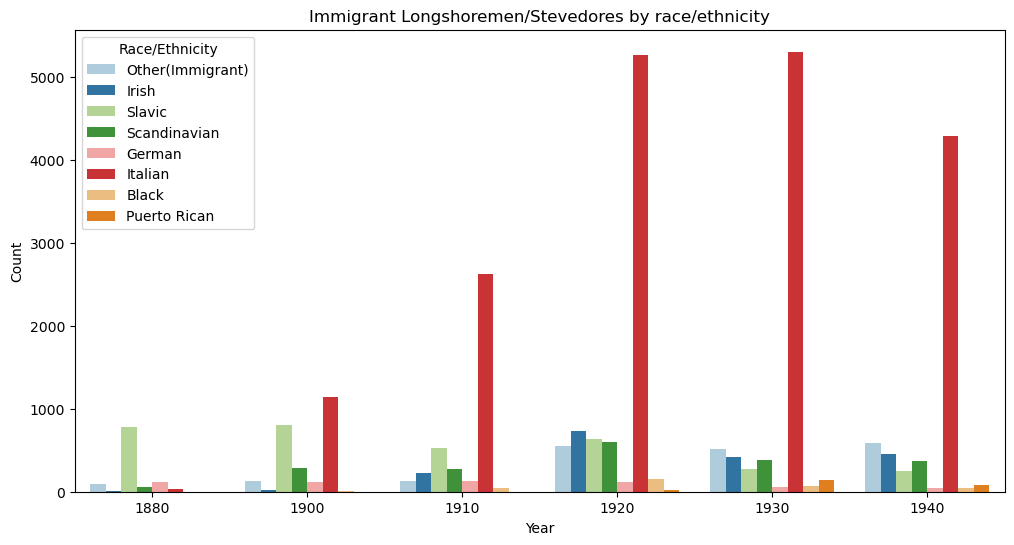

In [472]:
df_immdock = df[(df['ISIMMIGRANT'])&(df['ISDOCKWORKER'])]
# isolate just Stevedoring Population

plt.figure(figsize=(12, 6))
sns.countplot(data=df_immdock, x='YEAR', hue='DEMO_GROUP', palette='Paired')
plt.title("Immigrant Longshoremen/Stevedores by race/ethnicity")
plt.xlabel("Year")
plt.ylabel("Count")

plt.legend(title='Race/Ethnicity', labels= ['Other(Immigrant)', 'Irish', 'Slavic', 'Scandinavian', 'German', 'Italian', 'Black', 'Puerto Rican'])

plt.show()

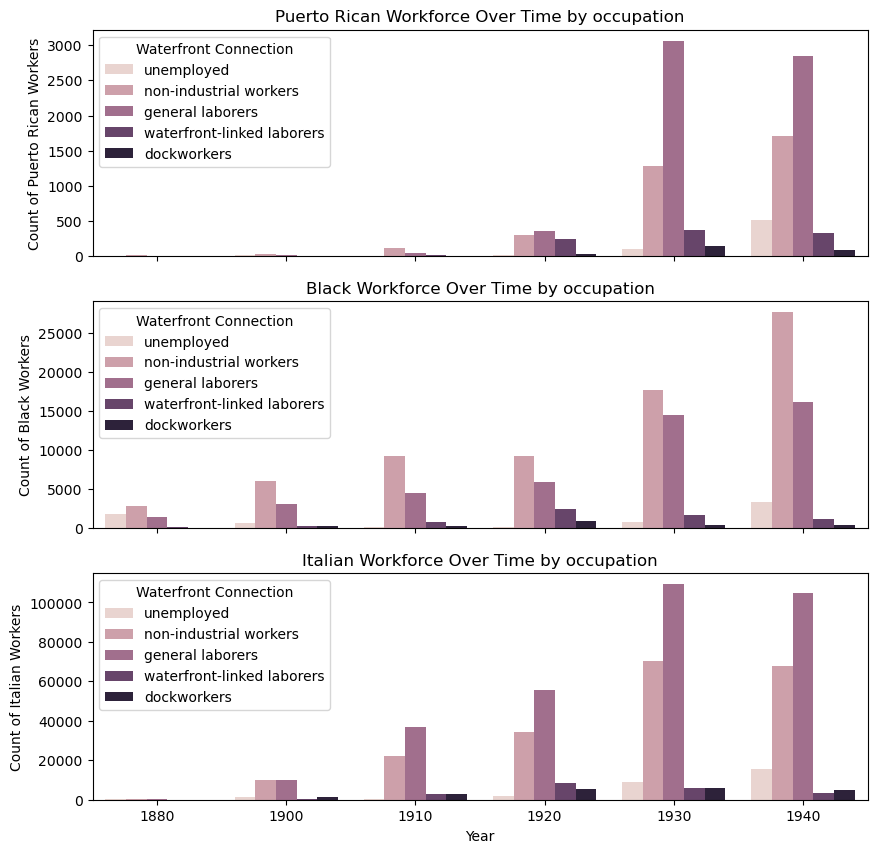

In [473]:
# plot Puerto Rican, Black, and Italian employment categories (waterfront relevant) over time IN BROOKLYN
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 10))

df_jobrecorded = drop_unrecorded_jobs(df)

df_pr = df_jobrecorded[df_jobrecorded['ISPR']]
df_it = df_jobrecorded[df_jobrecorded['ISITALIAN']]
df_blk = df_jobrecorded[df_jobrecorded['ISBLACK']]


sns.countplot(data=df_pr, x='YEAR', hue='JOB_GROUP', ax=axes[0])
axes[0].set_title("Puerto Rican Workforce Over Time by occupation")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Count of Puerto Rican Workers")
axes[0].legend(title='Waterfront Connection', labels=['unemployed', 'non-industrial workers', 'general laborers', 'waterfront-linked laborers', 'dockworkers'])


sns.countplot(data=df_blk, x='YEAR', hue='JOB_GROUP', ax=axes[1])
axes[1].set_title("Black Workforce Over Time by occupation")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Count of Black Workers")
axes[1].legend(title='Waterfront Connection', labels=['unemployed', 'non-industrial workers', 'general laborers', 'waterfront-linked laborers', 'dockworkers'])

sns.countplot(data=df_it, x='YEAR', hue='JOB_GROUP', ax=axes[2])
axes[2].set_title("Italian Workforce Over Time by occupation")
axes[2].set_xlabel("Year")
axes[2].set_ylabel("Count of Italian Workers")
axes[2].legend(title='Waterfront Connection', labels=['unemployed', 'non-industrial workers', 'general laborers', 'waterfront-linked laborers', 'dockworkers'])

plt.show()


Now let's look at the same thing in Red Hook

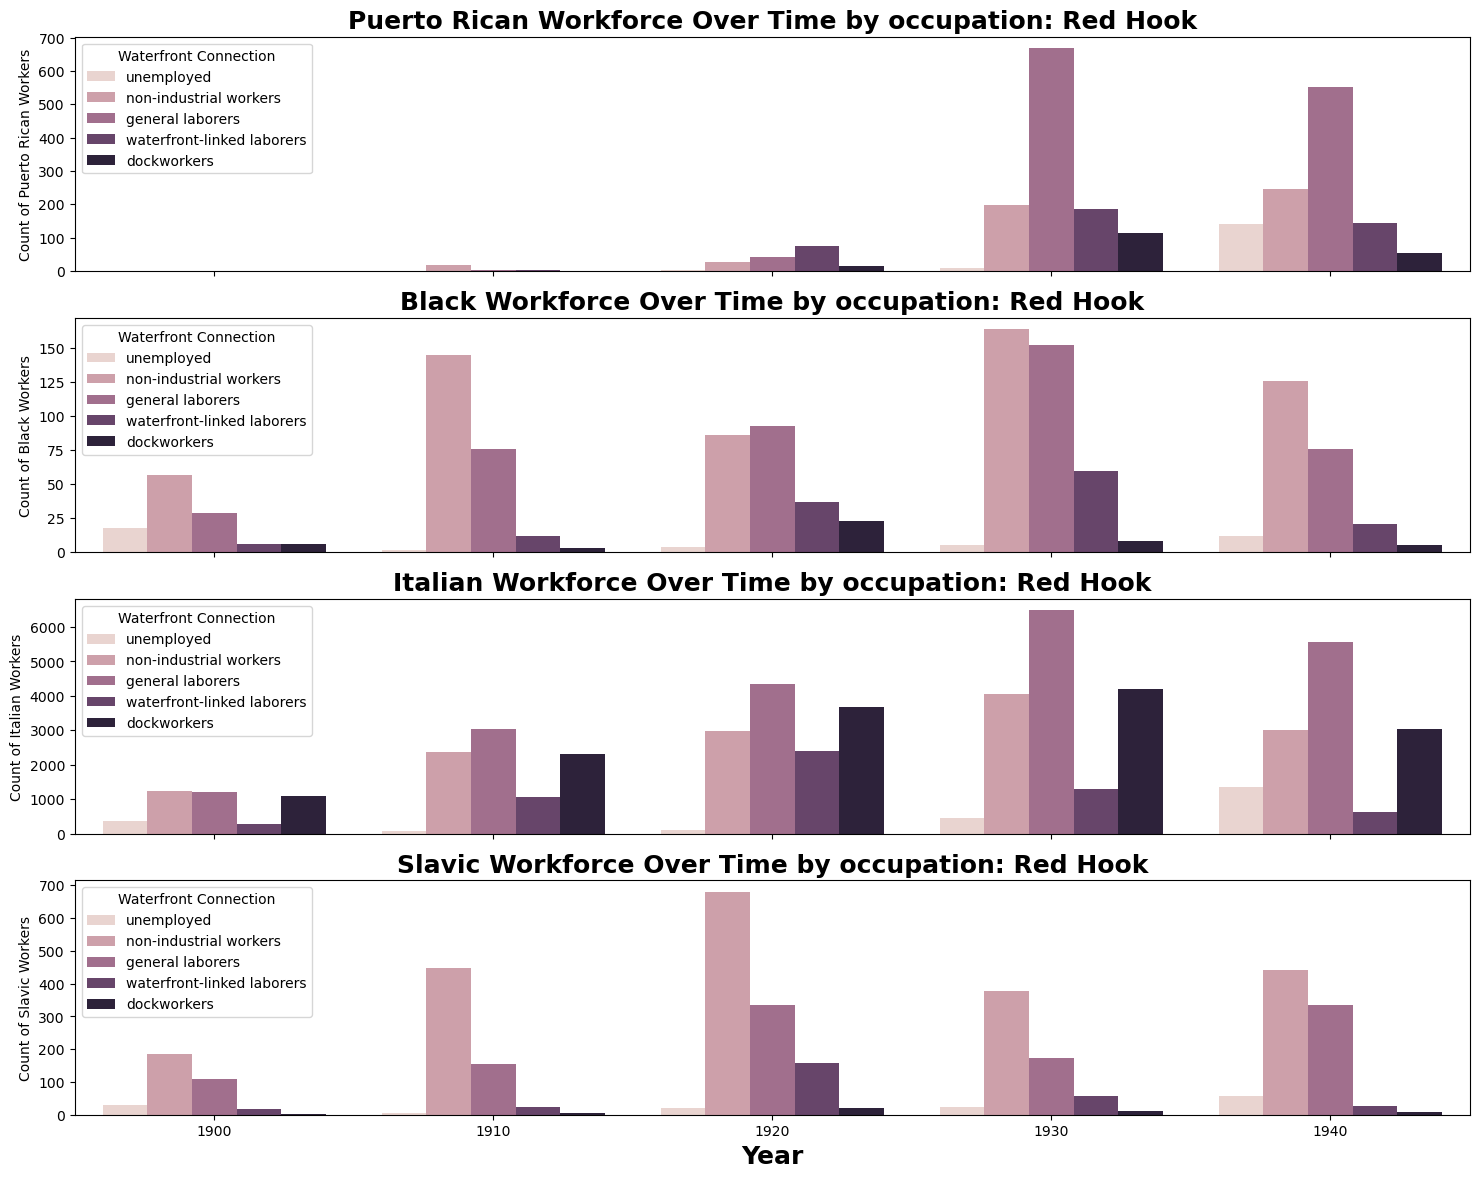

In [474]:
# plot Puerto Rican, Black, and Italian employment categories (waterfront relevant) over time IN RED HOOK
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(18, 14))

dfrh_jobrecorded = drop_unrecorded_jobs(df_redhook)

dfrh_pr = dfrh_jobrecorded[dfrh_jobrecorded['ISPR']]
dfrh_it = dfrh_jobrecorded[dfrh_jobrecorded['ISITALIAN']]
dfrh_blk = dfrh_jobrecorded[dfrh_jobrecorded['ISBLACK']]
dfrh_sv = dfrh_jobrecorded[dfrh_jobrecorded['ISSLAVIC']]


sns.countplot(data=dfrh_pr, x='YEAR', hue='JOB_GROUP', ax=axes[0])
axes[0].set_title("Puerto Rican Workforce Over Time by occupation: Red Hook", fontsize=18, weight='bold')
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Count of Puerto Rican Workers")
axes[0].legend(title='Waterfront Connection', labels=['unemployed', 'non-industrial workers', 'general laborers', 'waterfront-linked laborers', 'dockworkers'])


sns.countplot(data=dfrh_blk, x='YEAR', hue='JOB_GROUP', ax=axes[1])
axes[1].set_title("Black Workforce Over Time by occupation: Red Hook", fontsize=18, weight='bold')
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Count of Black Workers")
axes[1].legend(title='Waterfront Connection', labels=['unemployed', 'non-industrial workers', 'general laborers', 'waterfront-linked laborers', 'dockworkers'])

sns.countplot(data=dfrh_it, x='YEAR', hue='JOB_GROUP', ax=axes[2])
axes[2].set_title("Italian Workforce Over Time by occupation: Red Hook", fontsize=18, weight='bold')
axes[2].set_xlabel("Year", fontsize=18, weight='bold')
axes[2].set_ylabel("Count of Italian Workers")
axes[2].legend(title='Waterfront Connection', labels=['unemployed', 'non-industrial workers', 'general laborers', 'waterfront-linked laborers', 'dockworkers'])

sns.countplot(data=dfrh_sv, x='YEAR', hue='JOB_GROUP', ax=axes[3])
axes[3].set_title("Slavic Workforce Over Time by occupation: Red Hook", fontsize=18, weight='bold')
axes[3].set_xlabel("Year", fontsize=18, weight='bold')
axes[3].set_ylabel("Count of Slavic Workers")
axes[3].legend(title='Waterfront Connection', labels=['unemployed', 'non-industrial workers', 'general laborers', 'waterfront-linked laborers', 'dockworkers'])

plt.show()

Fascinating! There is so much to take away from this data. 

Text(0.5, 1.0, 'Most Common Puerto Rican Occupation Codes')

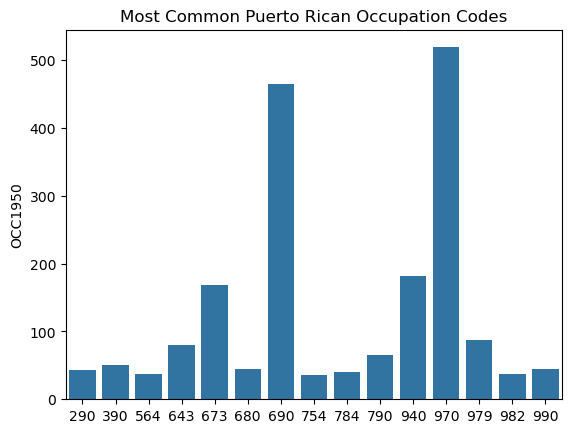

In [475]:
sns.barplot(data=df_redhook.loc[(df_redhook['ISPR'])&(df_redhook['OCC_UNKNOWN']==False), 'OCC1950'].value_counts().head(15))
plt.title('Most Common Puerto Rican Occupation Codes')

690 and 970 both being the catch-all codes for their respective categories (Operatives and Laborers) suggests a more day-laborer role of these workers, although there really is no way of telling completely. Seeing as there is a designated code for Dockworkers which is by no means generally ignored, there is little reason to believe that many of these laborers work on the docks, unless the way they were recorded differs from other workers. There is no reason to speculate, though, so we will accept these codes at face value.

940: Longshoremen/Stevedores
673: Sailors and Deck Hands
- This code is incredibly interesting, and according to the alphabetic guidebook, really only applies to people on the ships themselves. Was there a serious population of Puerto Rican sailors, deck hands, or ferrymen living in Brooklyn? None of my other sources suggest this, but this history is not very documented, so it is definitely possible.

Text(0.5, 1.0, 'Most Common Italian Occupation Codes')

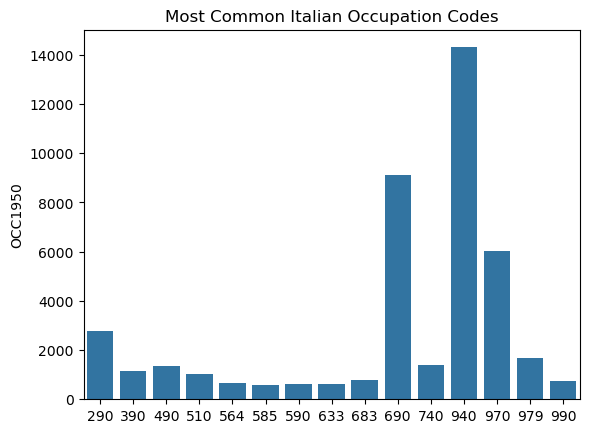

In [476]:
sns.barplot(data=df_redhook.loc[(df_redhook['ISITALIAN'])&(~df_redhook['OCC1950'].isin([0, 999])), 'OCC1950'].value_counts().head(15))
plt.title('Most Common Italian Occupation Codes')

Some codes to note:
246: Construction
546: Water Transportation
446: Manufacturing - Apparel and accessories
499: Not Specified Manufacturing

679 and above are service industry jobs

In terms of industrial labor, Construction, Manufactruring, and "Water Transportation" ostensibly maritime industry, dominates.

Finally, let's make a heatmap of that percentage dataframe we made earlier. It still isn't the perfect way of visualizing the imbalances, and I may need to refine my categorization a bit more, but it's a step in the right direction.

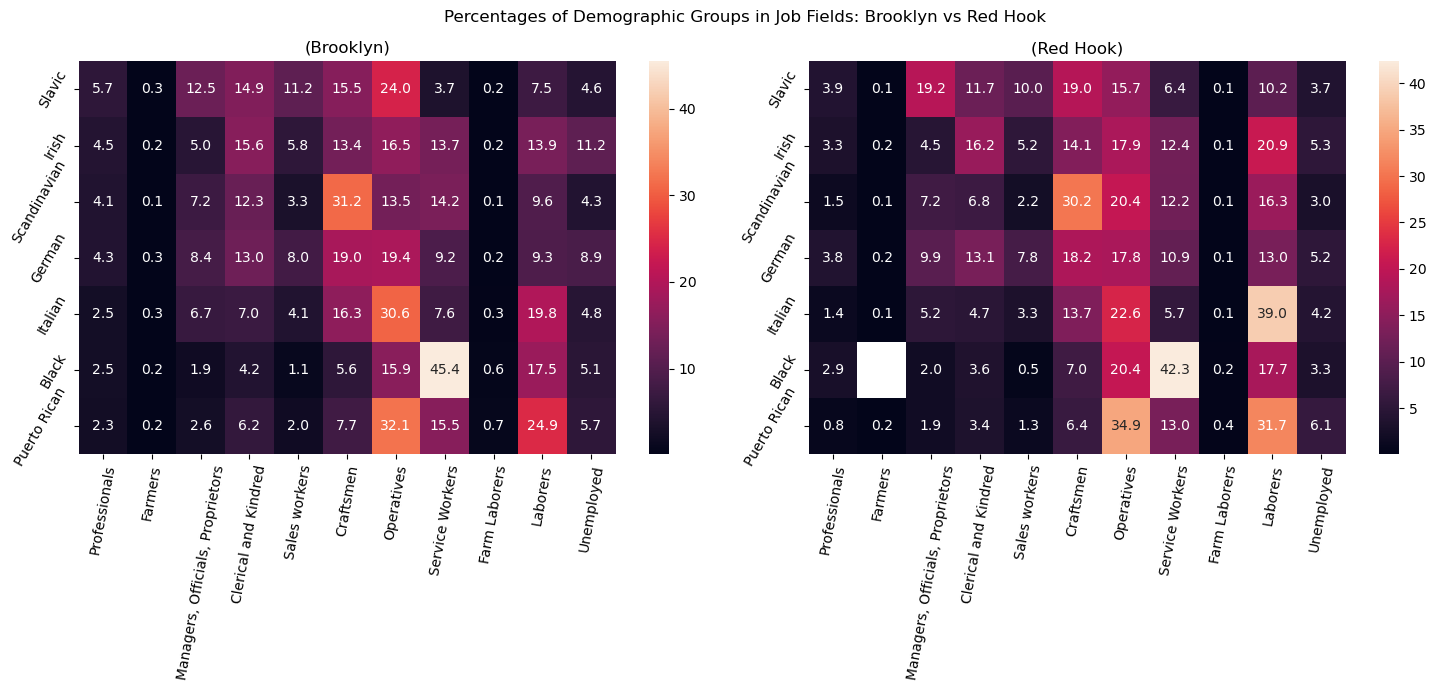

In [477]:
# Create the pivot table
def pivotdf(df):
    dfcounts = reduce_demographic(drop_unrecorded_jobs(df)).groupby(['DEMO_GROUP', 'OCC_CATEGORY']).size().reset_index().pivot_table(values=0,columns='OCC_CATEGORY',index=['DEMO_GROUP'])

    dfcounts.columns = dfcounts.columns.get_level_values(0)

    # Rename the columns to descriptive names
    dfcounts = dfcounts.rename(columns={
        0: 'Professionals', 
        1: 'Farmers', 
        2: 'Managers, Officials, Proprietors', 
        3: 'Clerical and Kindred',  
        4: 'Sales workers',
        5: 'Craftsmen',
        6: 'Operatives',
        7: 'Service Workers',
        8: 'Farm Laborers',
        9: 'Laborers',
        10: 'Unemployed'
        },
                           index={2: 'Slavic', 3: 'Irish', 4: 'Scandinavian',  5: 'German', 6: 'Italian', 7: 'Black', 8: 'Puerto Rican'})

    # We can also make the same dataframe display the percentages of each demographic group population in each labor category
    dfpercentages = dfcounts.div(dfcounts.sum(axis=1), axis=0) * 100
    
    return dfcounts, dfpercentages


bkpivot, bkpercentages = pivotdf(df)

rhpivot, rhpercentages = pivotdf(df_redhook)


# Now we can graph this dataframe for a heatmap

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle("Percentages of Demographic Groups in Job Fields: Brooklyn vs Red Hook")

sns.heatmap(bkpercentages, annot=True, fmt=".1f", ax=axes[0])
axes[0].set_title("(Brooklyn)")
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].tick_params(axis='x', rotation=80)
axes[0].tick_params(axis='y', rotation=60)


sns.heatmap(rhpercentages, annot=True, fmt=".1f", ax=axes[1])
axes[1].set_title("(Red Hook)")
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', rotation=80)
axes[1].tick_params(axis='y', rotation=60)

plt.tight_layout()

plt.show()

# Interesting to see how, in Brooklyn, a much larger share of Italians are Longshoremen, while Black and Puerto Rican workers are disporportionately funnelled to more basic labor occupations

This result is very interesting, indicating a clear funnelling of Black workers into service jobs, and Italians, Irish and Puerto Ricans into Laborer Jobs. In Red Hook specifically, it's interesting to note that more Italians are designated as "Laborers" while more Puerto Ricans are "operatives".

It's also clear that German, Slavic, and even Irish populations are more likely to hold clerical and manegerial, and artisan jobs, which are likely higher paying.

It should be noted that there is some muddy overlap and discrepancy between/among the "Operative" and "Laborer" occupation classification: It is sometimes hard to tell what "Operative" Jobs are more more technical jobs, and which are more general factory machinery jobs.

## Spatial Plotting
We can start plotting economic and demographic information based on these enumeration districts

**Let's Start by Exporting Our Geodataframes Into Sapefiles**
Since we're essentially done manipulating our data, we can take things to GIS software for more visualization options.

In [478]:
geopackage = '/Users/raoulherskoits/Documents/GIS Work/BMT_Thesis_largedatasets/created_files/redhookCensus.gpkg'

gdf_1900.to_file(geopackage, layer='1900', driver='GPKG')
gdf_1910.to_file(geopackage, layer='1910', driver='GPKG')
gdf_1920.to_file(geopackage, layer='1920', driver='GPKG')
gdf_1930.to_file(geopackage, layer='1930', driver='GPKG')
gdf_1940.to_file(geopackage, layer='1940', driver='GPKG')

In [494]:
# Make a function that easily allows us to make a chloropleth maps comparing values over time

def countplot_overtime(column, name):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    gdf_1900.plot(column=column, ax=axes[0, 0], legend=True).set_axis_off()
    gdf_1910.plot(column=column, ax=axes[0, 1], legend=True).set_axis_off()
    gdf_1920.plot(column=column, ax=axes[0, 2], legend=True).set_axis_off()
    gdf_1930.plot(column=column, ax=axes[1, 0], legend=True).set_axis_off()
    gdf_1940.plot(column=column, ax=axes[1, 1], legend=True).set_axis_off()
    sns.countplot(data=df_redhook[df_redhook[column]!=0], x='YEAR' , ax=axes[1, 2])

    axes[0, 0].set_title('1900')
    axes[0, 1].set_title('1910')
    axes[0, 2].set_title('1920')
    axes[1, 0].set_title('1930')
    axes[1, 1].set_title('1940')
    axes[1, 2].set_title('total count')
    axes[1, 2].set_ylabel('')

    fig.suptitle(name, fontsize=24)


    plt.show()

def pctplot_overtime(column, name):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    gdf_1900.plot(column=f'{column}_PERCENT', ax=axes[0, 0], legend=True).set_axis_off()
    gdf_1910.plot(column=f'{column}_PERCENT', ax=axes[0, 1], legend=True).set_axis_off()
    gdf_1920.plot(column=f'{column}_PERCENT', ax=axes[0, 2], legend=True).set_axis_off()
    gdf_1930.plot(column=f'{column}_PERCENT', ax=axes[1, 0], legend=True).set_axis_off()
    gdf_1940.plot(column=f'{column}_PERCENT', ax=axes[1, 1], legend=True).set_axis_off()
    # sns.barplot(data=df_redhook, x='YEAR', y=(column / ))

    axes[0, 0].set_title('1900')
    axes[0, 1].set_title('1910')
    axes[0, 2].set_title('1920')
    axes[1, 0].set_title('1930')
    axes[1, 1].set_title('1940')
    # axes[1, 2].set_title('total count')
    # axes[1, 2].set_ylabel('')

    fig.suptitle(name, fontsize=24)


    plt.show()

### General Population Visualizations

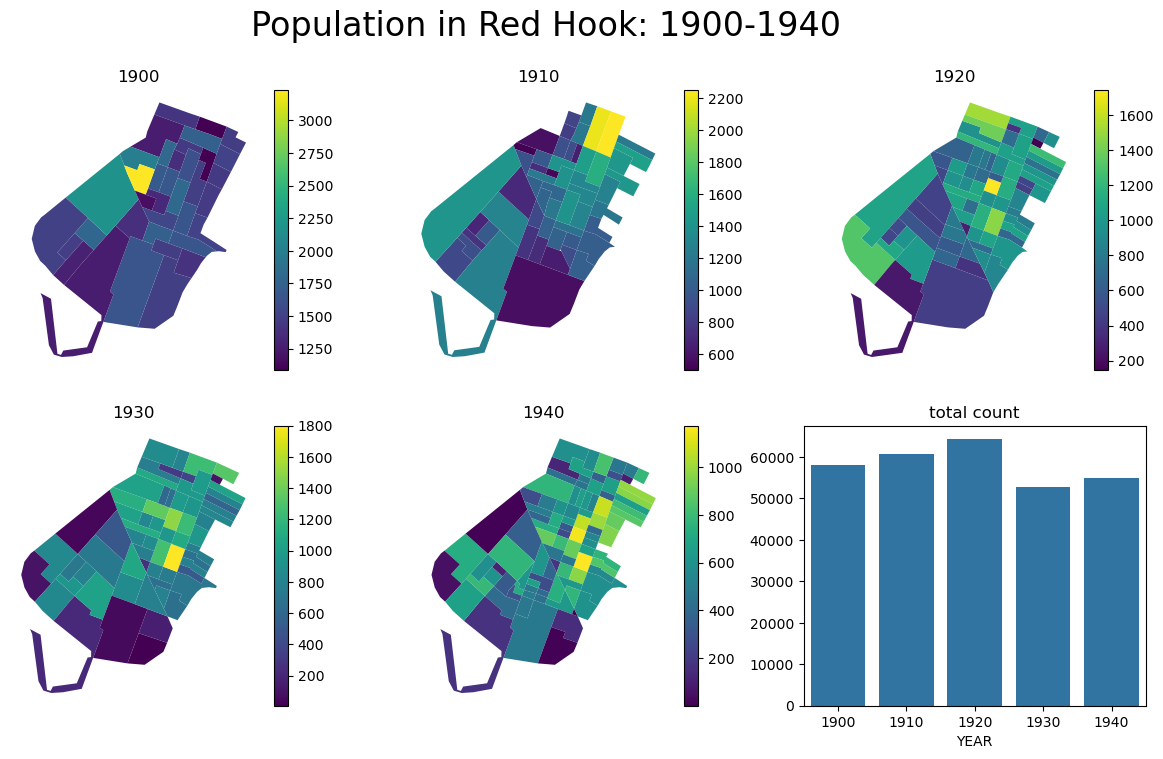

In [495]:
countplot_overtime('TOTAL_POP', 'Population in Red Hook: 1900-1940')

In [496]:
gdf_1930['ISITALIAN_PERCENT'] 

0     24.941452
1     71.907958
2     42.561983
3      1.063830
4      0.000000
        ...    
61    42.153494
62    25.128205
63    16.326531
64    38.277512
65    57.233503
Name: ISITALIAN_PERCENT, Length: 66, dtype: float64

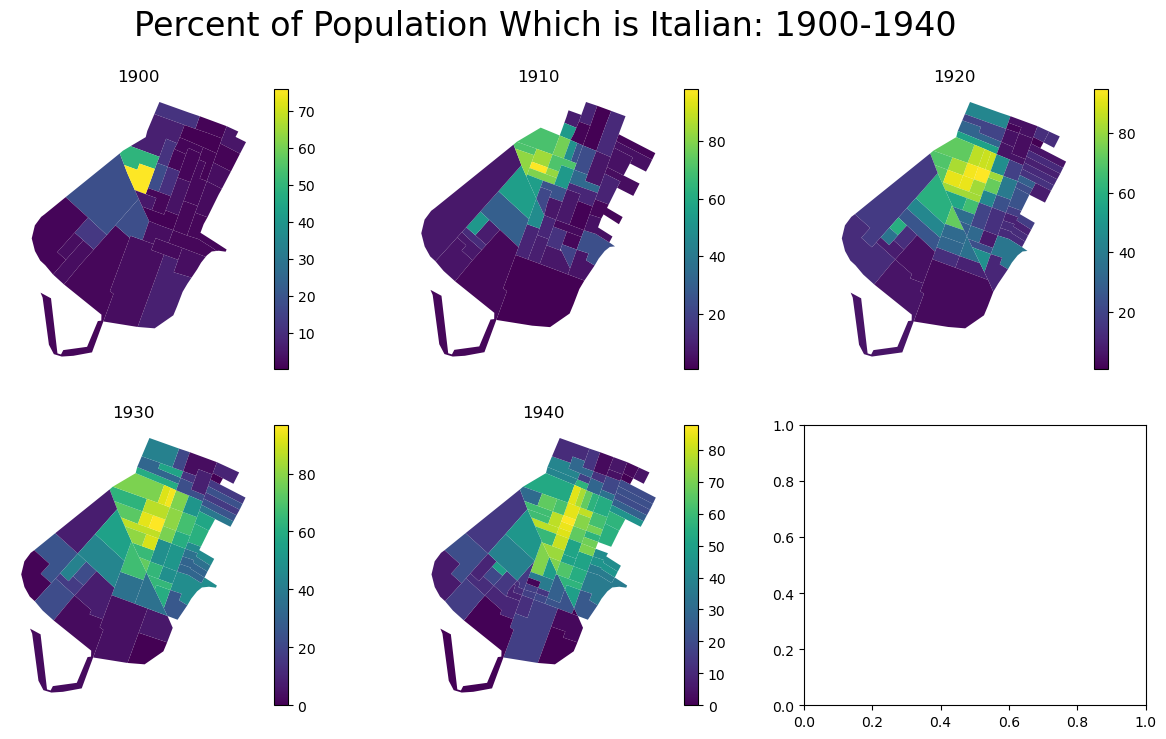

In [497]:
pctplot_overtime('ISITALIAN', 'Percent of Population Which is Italian: 1900-1940')

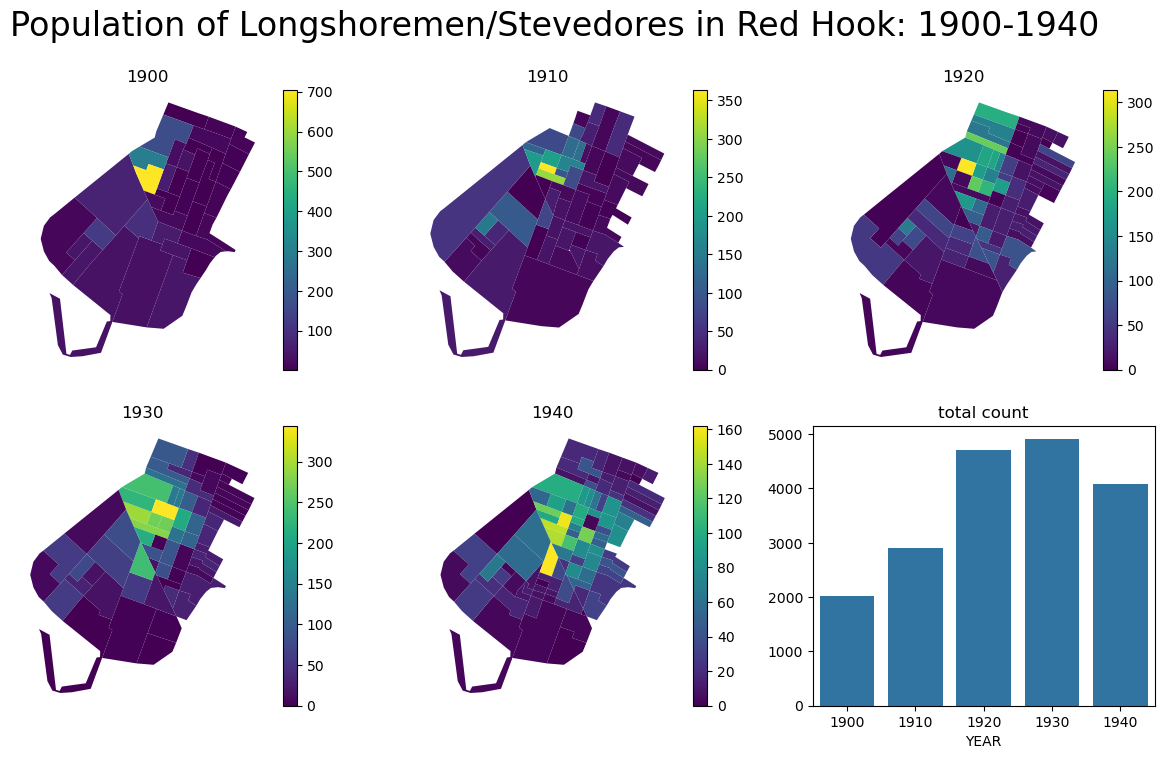

In [498]:
countplot_overtime('ISDOCKWORKER', 'Population of Longshoremen/Stevedores in Red Hook: 1900-1940')

Notice how the Italian population edges slightly closer to the docks than the general population, and the Longshoremen slightly closer than them. The degree of difference is almost negligeable (due to the great overlap betwee the three) but worth noting.

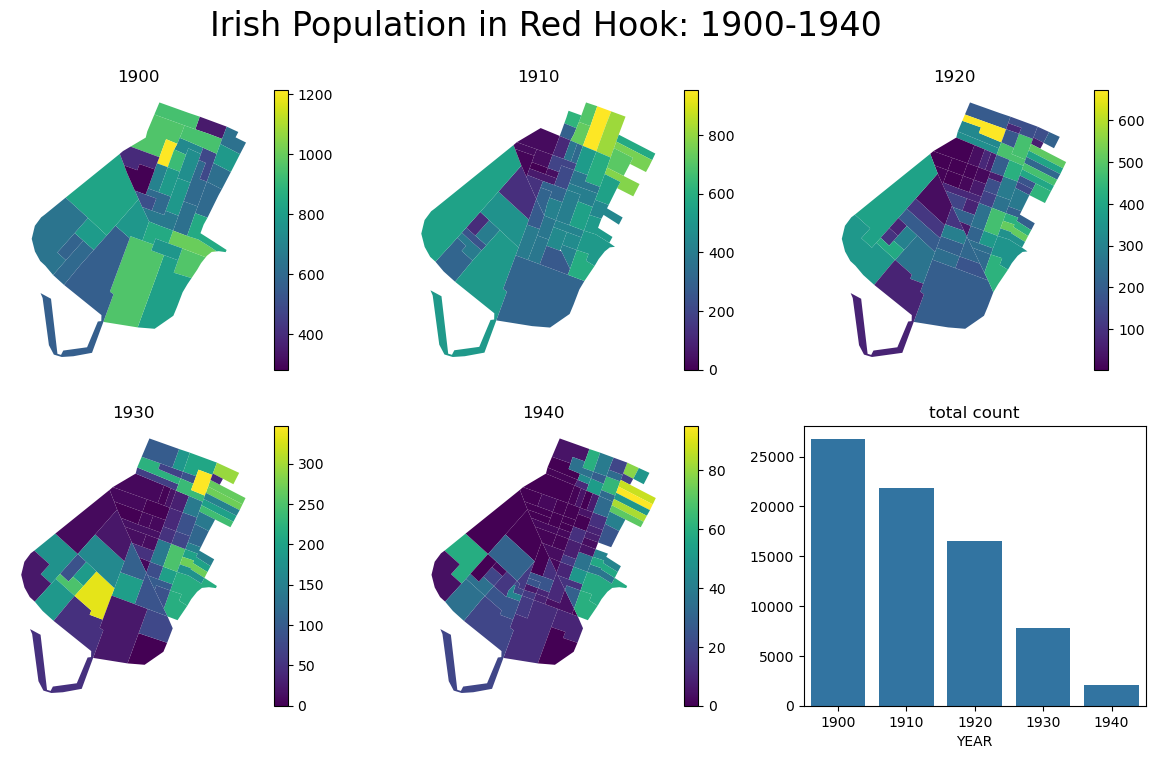

In [499]:
countplot_overtime('ISIRISH', 'Irish Population in Red Hook: 1900-1940')

Note the absolute hole in the Irish population where the Italians are located even as early as 1900!

#### Minority Populations

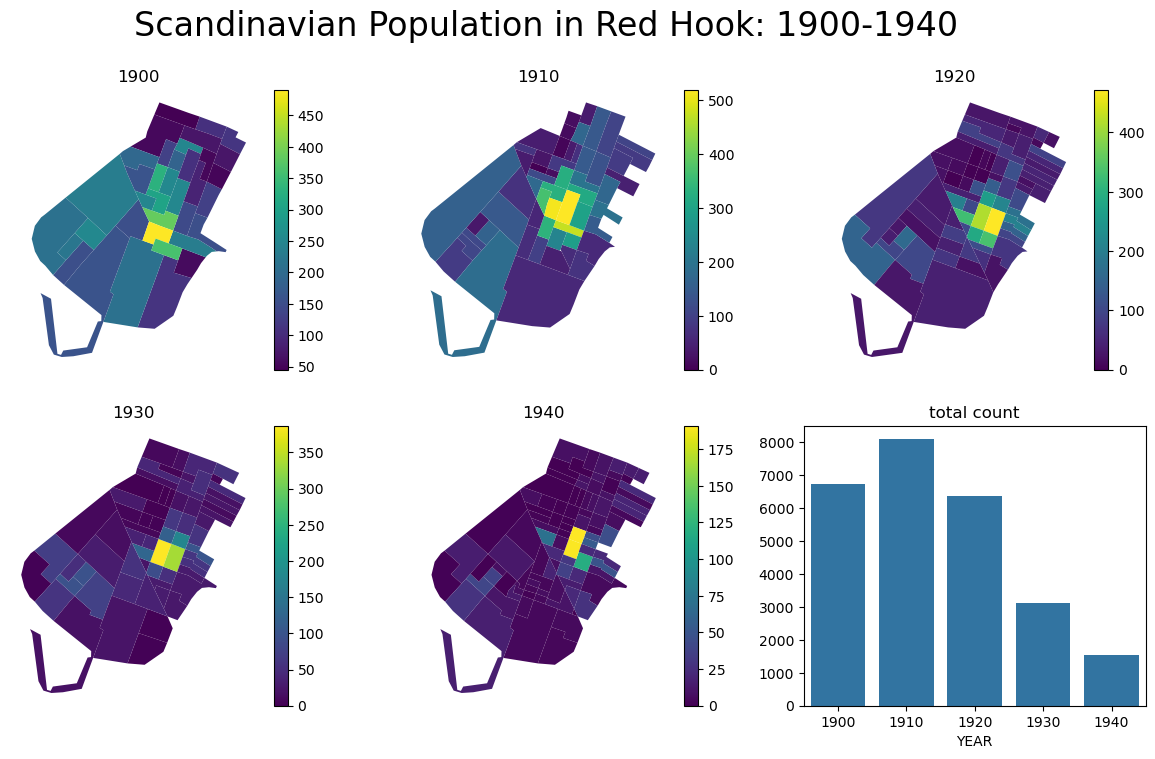

In [500]:
countplot_overtime('ISSCANDI', 'Scandinavian Population in Red Hook: 1900-1940')

The famous "Tin Can City" Seems to not make up the majority of Scandinavian Red Hook residents in the 1930's and 1940's

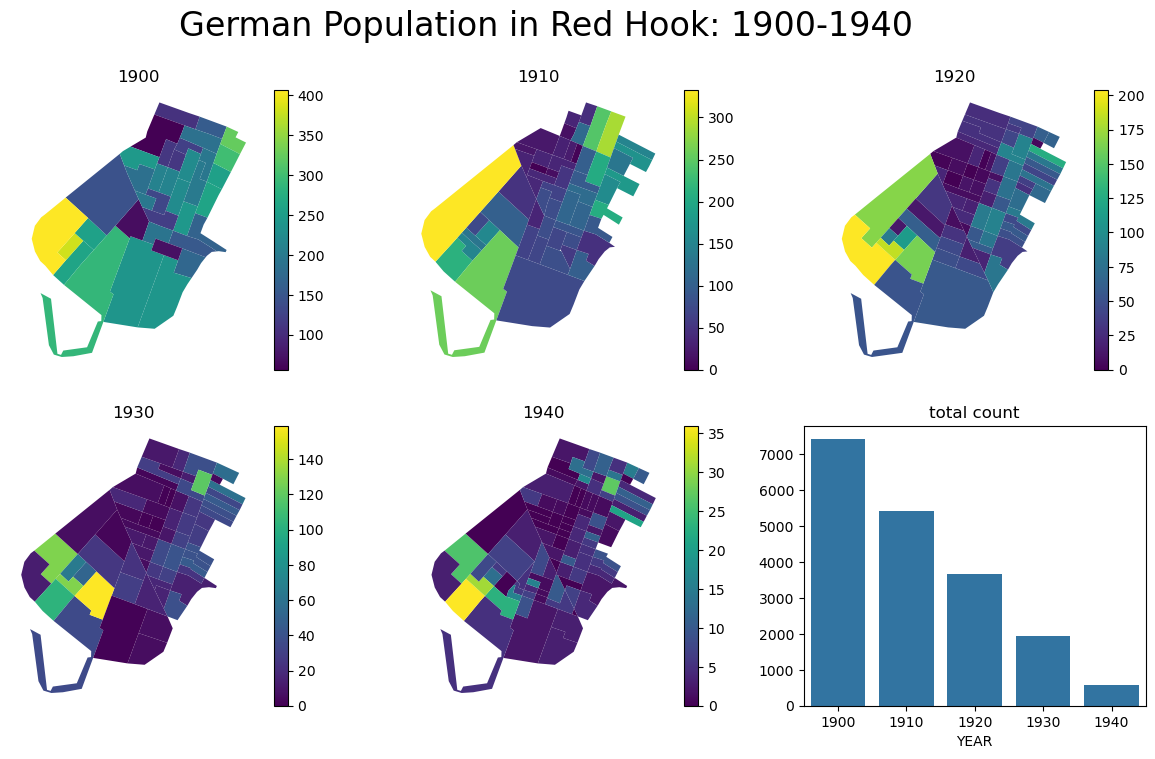

In [501]:
countplot_overtime('ISGERMAN', 'German Population in Red Hook: 1900-1940')

#### Key Occupation Concentrations
Longshoremen/Stevedore concentrations are found above, but other occupations are are worth plotting

In [502]:
[column for column in gdf_1900.columns if column[0:4]=='OCC_']

['OCC_UNKNOWN',
 'OCC_PRO/TECH',
 'OCC_FARM',
 'OCC_MAN/OFF/PROP',
 'OCC_CLERICAL',
 'OCC_SALES',
 'OCC_CRAFTS',
 'OCC_OP',
 'OCC_SERVICE',
 'OCC_FARMLAB',
 'OCC_LAB',
 'OCC_UNKNOWN_PERCENT']

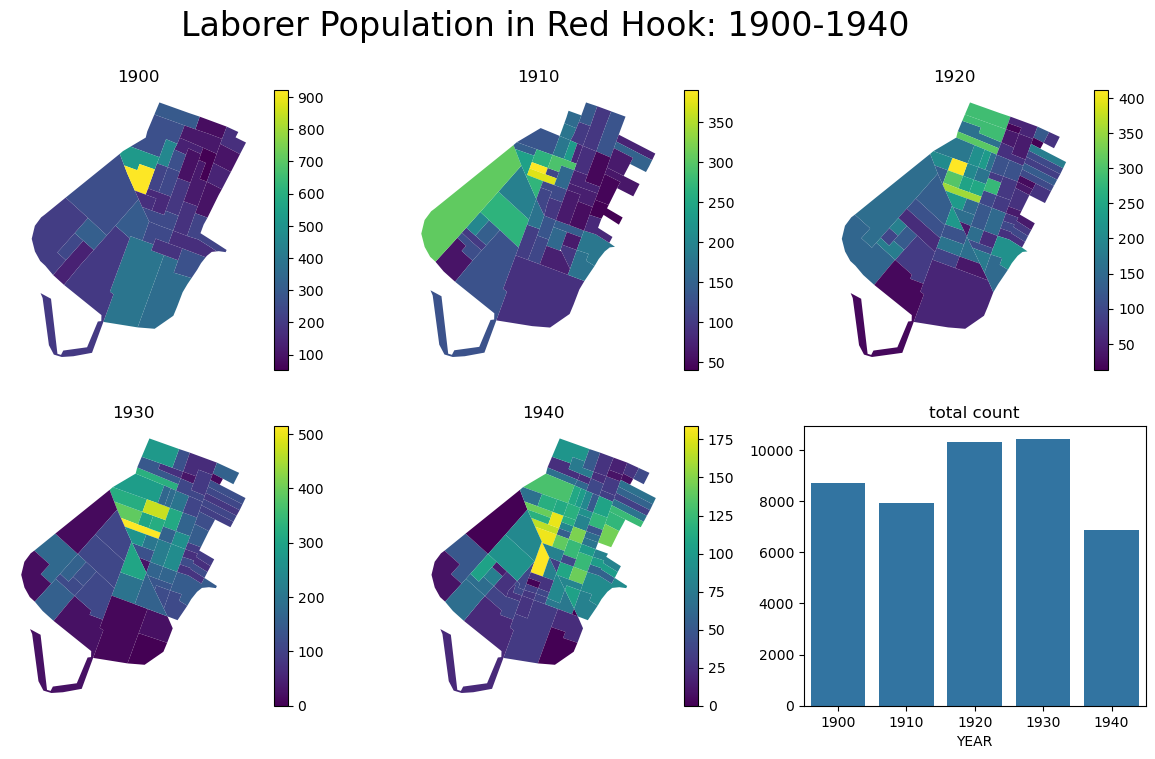

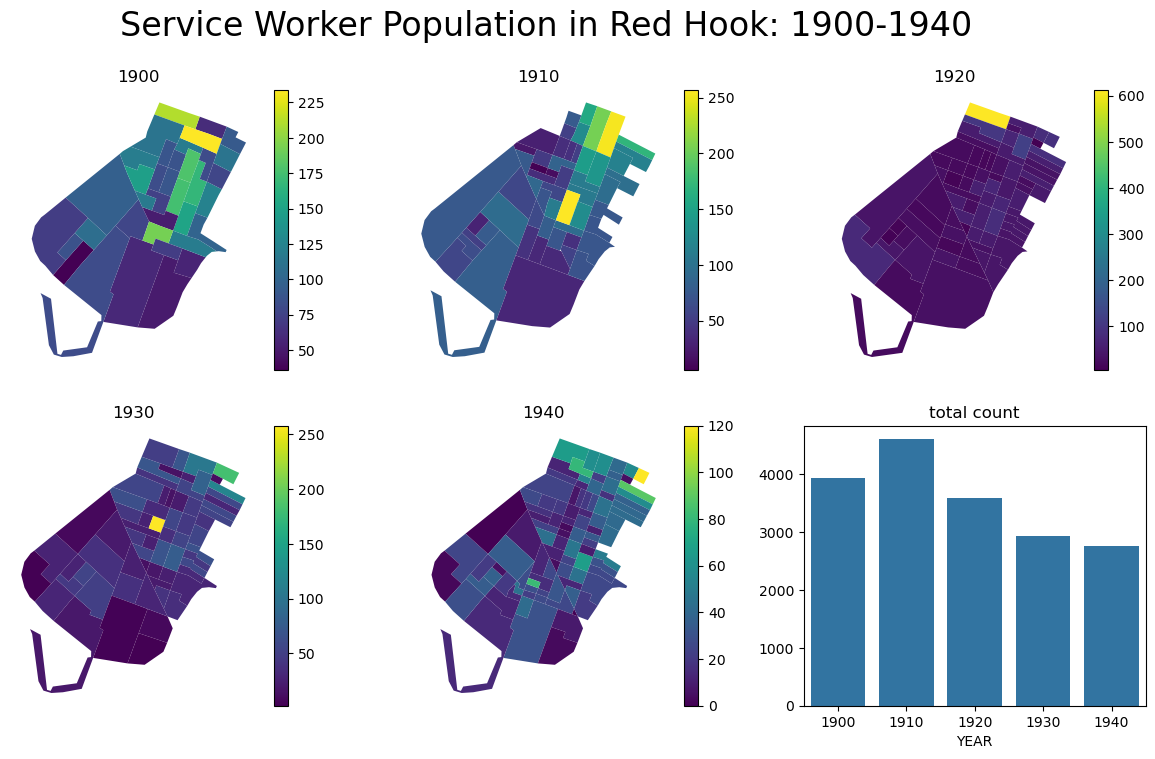

In [503]:
countplot_overtime('OCC_LAB', 'Laborer Population in Red Hook: 1900-1940')
countplot_overtime('OCC_SERVICE', 'Service Worker Population in Red Hook: 1900-1940')

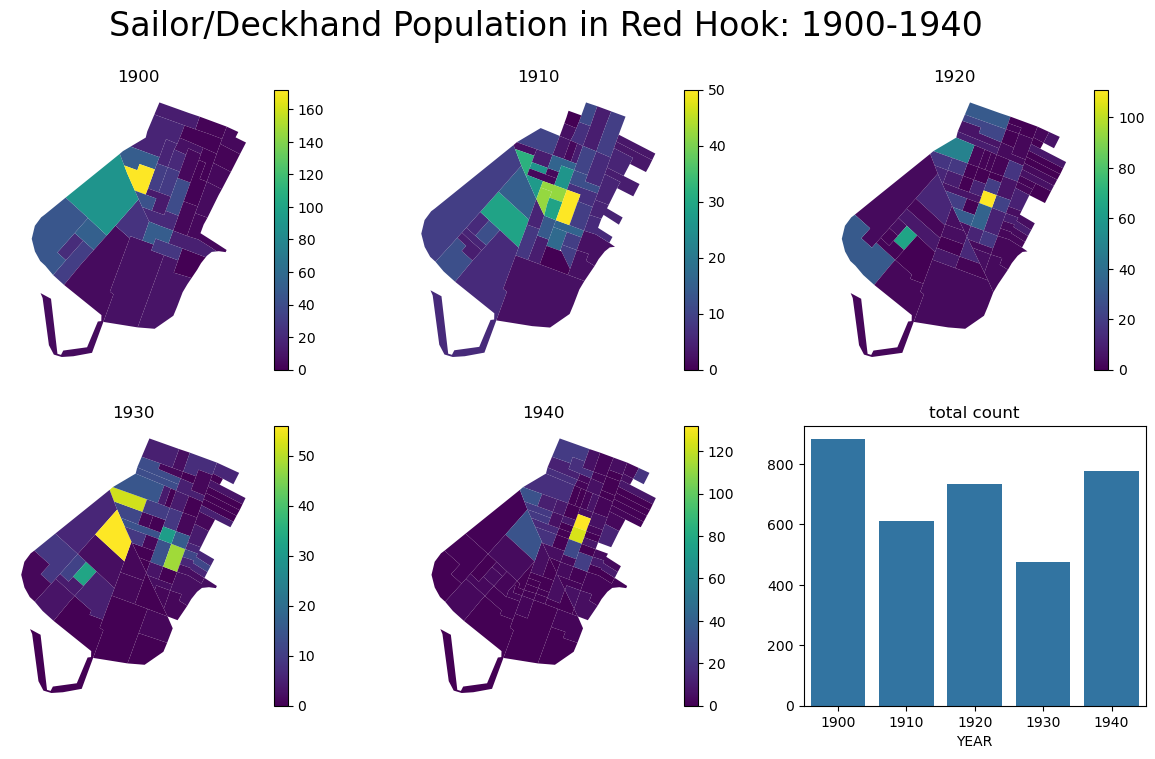

In [504]:
countplot_overtime('OCC1950_673', 'Sailor/Deckhand Population in Red Hook: 1900-1940')

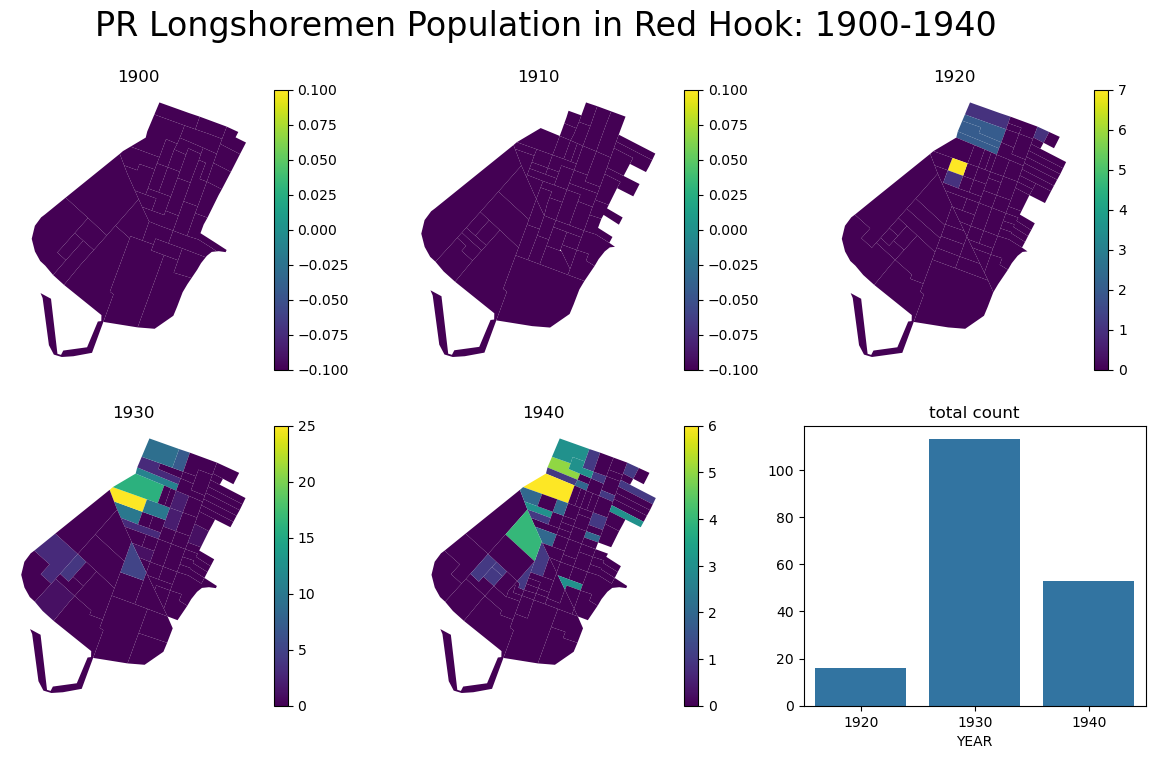

In [505]:
countplot_overtime('ISPR_AND_ISDOCKWORKER', 'PR Longshoremen Population in Red Hook: 1900-1940')


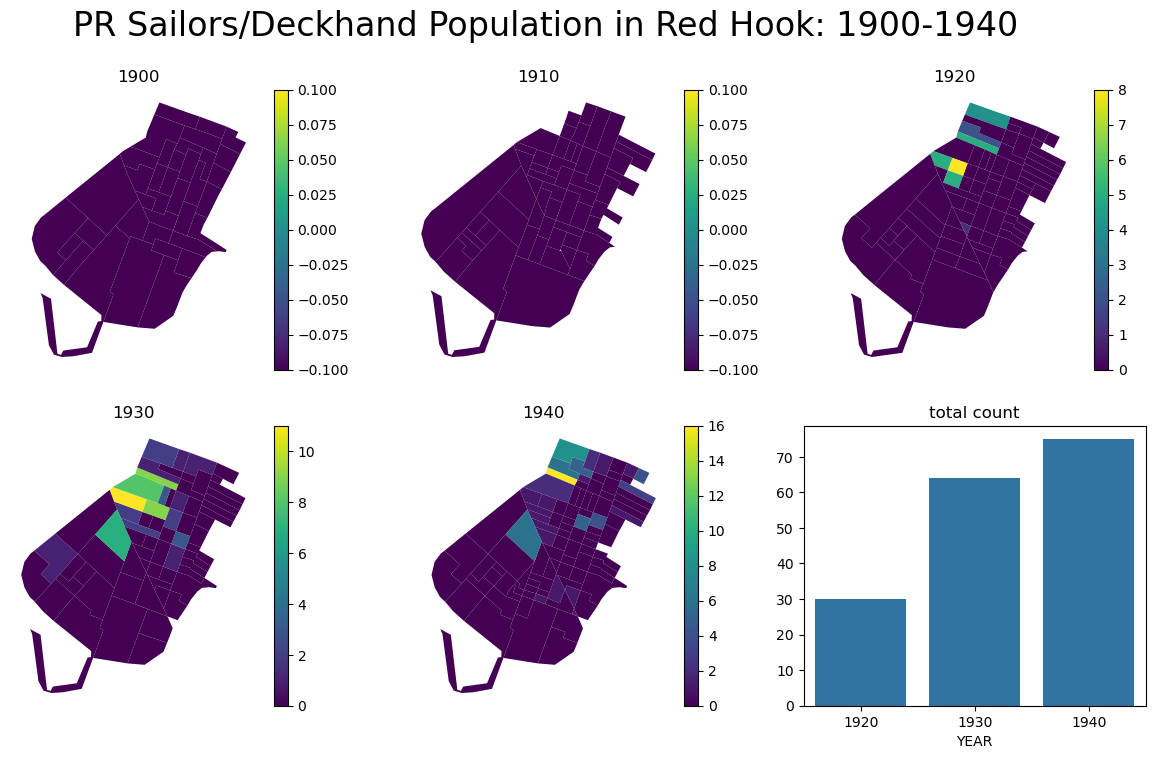

In [506]:
countplot_overtime('ISPR_AND_OCC1950_673', 'PR Sailors/Deckhand Population in Red Hook: 1900-1940')
